In [1]:
import os
import mc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices, build_design_matrices
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from scipy import stats
from matplotlib.ticker import PercentFormatter
from scipy.ndimage import gaussian_filter1d

In [2]:
def get_data(sub, trials):
    data_folder = "/Users/xpsy1114/Documents/projects/multiple_clocks/data/ephys_humans/derivatives"
    if not os.path.isdir(data_folder):
        print("running on ceph")
        data_folder = "/ceph/behrens/svenja/human_ABCD_ephys/derivatives"
    if trials == 'residualised':
        res_data = True
    else:
        res_data = False
    data_norm = mc.analyse.helpers_human_cells.load_norm_data(data_folder, [f"{sub:02}"], res_data = res_data)
    return data_norm, data_folder 

In [3]:
def compute_perm_pvalues_groupby(df):
    group_cols = ["session", "neuron", "roi", "model", "term"]

    real  = df[df["permuted"] == False].copy()
    perms = df[df["permuted"] == True].copy()

    perm_groups = perms.groupby(group_cols)

    real["p_perm_t"] = np.nan
    real["p_perm_F"] = np.nan

    for key, real_row in real.groupby(group_cols):
        # key is a tuple (session, neuron, roi, model, term)
        if key not in perm_groups.groups:
            continue

        perm_group = perm_groups.get_group(key)

        t_real = real_row["t"].iloc[0]
        F_real = real_row["F"].iloc[0]

        t_perm = perm_group["t"].to_numpy()
        F_perm = perm_group["F"].to_numpy()

        p_t = (np.sum(np.abs(t_perm) >= abs(t_real)) + 1) / (len(t_perm) + 1)
        p_F = (np.sum(F_perm >= F_real) + 1) / (len(F_perm) + 1)

        # assign same p-values to that real row (usually just 1 row anyway)
        real.loc[real_row.index, "p_perm_t"] = p_t
        real.loc[real_row.index, "p_perm_F"] = p_F

    return real


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_perm_significance_ABCD_cells(df):
    """
    df: dataframe with columns including:
        ['session','neuron','roi','model','term',
         'p_perm_t','p_perm_F','permuted', ...]
    """

    terms = ["A", "B", "C", "D"]

    # Colors for each term: orange → purple
    colors = {
        "A": "#d95f02",  # dark orange
        "B": "#fe9929",  # bright orange
        "C": "#9e9ac8",  # bright-ish purple
        "D": "#542788",  # dark purple
    }
    bg_color = "#f0f0f0"  # very light grey for 100% bar

    # --- Filter to empirical rows for model M1_main and terms A–D ---
    real = df[
        (df["permuted"] == False) &
        (df["model"] == "M1_main") &
        (df["term"].isin(terms))
    ].copy()

    # Ensure one row per (session, neuron, roi, model, term)
    real = real.drop_duplicates(["session", "neuron", "roi", "model", "term"])

    # Define "cell" as (session, neuron) with its ROI
    cells = real[["session", "neuron", "roi"]].drop_duplicates()

    # ---------------- OVERALL PANEL (using p_perm_t) ----------------

    # Total unique cells (across all ROIs)
    all_cells = cells[["session", "neuron"]].drop_duplicates()
    total_cells_all = all_cells.shape[0]

    # For each term, count cells with p_perm_t < 0.05
    sig_cells_t = (
        real[real["p_perm_t"] < 0.05][["term", "session", "neuron"]]
        .drop_duplicates()
    )
    sig_counts_overall = (
        sig_cells_t.groupby("term").size().reindex(terms, fill_value=0)
    )

    props_overall = sig_counts_overall / total_cells_all

    # ---------------- BY-ROI PANEL (using p_perm_F) ----------------

    # Total cells per ROI (denominator)
    cells_per_roi = (
        cells[["roi", "session", "neuron"]]
        .drop_duplicates()
        .groupby("roi")
        .size()
    )
    rois = cells_per_roi.index.to_list()

    # Significant cells per (ROI, term)
    sig_cells_F = (
        real[real["p_perm_t"] < 0.05][["roi", "term", "session", "neuron"]]
        .drop_duplicates()
    )
    sig_counts = (
        sig_cells_F.groupby(["roi", "term"])
        .size()
        .unstack("term", fill_value=0)
    )

    # Make sure we have all ROIs and terms in the table
    sig_counts = sig_counts.reindex(index=rois, columns=terms, fill_value=0)

    # Proportions by ROI and term: N_sig(R,T) / N_total(R)
    props_by_roi = sig_counts.div(cells_per_roi, axis=0)  # broadcast over index

    # ---------------- PLOTTING ----------------

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    # ===== Left panel: overall =====
    ax1 = axes[0]
    x1 = np.arange(len(terms))

    # background 100% bars
    ax1.bar(x1, [1] * len(terms), color=bg_color, width=0.8, zorder=0)

    # colored bars for proportions
    bar_colors = [colors[t] for t in terms]
    ax1.bar(x1, props_overall.values, color=bar_colors, width=0.5, zorder=1)

    ax1.set_xticks(x1)
    ax1.set_xticklabels(terms)
    ax1.set_ylim(0, 1)
    ax1.set_ylabel("Proportion of cells significant\n(p_perm_t < 0.05)")
    ax1.set_title("Overall (all cells)")
    ax1.yaxis.grid(True, linestyle="--", alpha=0.3)

    # ===== Right panel: by ROI =====
    ax2 = axes[1]
    x2 = np.arange(len(rois))
    bar_width = 0.18

    # term-specific offsets so bars sit side-by-side per ROI
    offsets = {
        "A": -1.5 * bar_width,
        "B": -0.5 * bar_width,
        "C":  0.5 * bar_width,
        "D":  1.5 * bar_width,
    }

    for term in terms:
        positions = x2 + offsets[term]
        vals = props_by_roi[term].values  # proportion for each ROI for this term

        # background 100% bar for each term/ROI
        ax2.bar(positions, [1] * len(rois), color=bg_color,
                width=bar_width, zorder=0)

        # colored bar with actual proportion
        ax2.bar(positions, vals, color=colors[term],
                width=bar_width, zorder=1, label=term)

    ax2.set_xticks(x2)
    ax2.set_xticklabels(rois, rotation=45, ha="right")
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("Proportion of cells significant\n(p_perm_F < 0.05)")
    ax2.set_title("By ROI")
    ax2.yaxis.grid(True, linestyle="--", alpha=0.3)
    ax2.legend(title="Term", frameon=False)

    plt.suptitle("Permutation-based significance (A–D), model M1_main", fontsize=12)
    plt.show()

    return fig, axes


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_perm_significance_interaction_ABCD_cells(df):
    """
    df: dataframe with columns including:
        ['session','neuron','roi','model','term',
         'p_perm_t','p_perm_F','permuted', ...]
    """

    terms = ['A_rep','B_rep','C_rep', 'D_rep']

    # Colors for each term: orange → purple
    colors = {
        "A_rep": "#d95f02",  # dark orange
        "B_rep": "#fe9929",  # bright orange
        "C_rep": "#9e9ac8",  # bright-ish purple
        "D_rep": "#542788",  # dark purple
    }
    bg_color = "#f0f0f0"  # very light grey for 100% bar

    # --- Filter to empirical rows for model M1_main and terms A–D ---
    real = df[
        (df["permuted"] == False) &
        (df["model"] == "M2_interact") &
        (df["term"].isin(terms))
    ].copy()

    # Ensure one row per (session, neuron, roi, model, term)
    real = real.drop_duplicates(["session", "neuron", "roi", "model", "term"])

    # Define "cell" as (session, neuron) with its ROI
    cells = real[["session", "neuron", "roi"]].drop_duplicates()

    # ---------------- OVERALL PANEL (using p_perm_t) ----------------

    # Total unique cells (across all ROIs)
    all_cells = cells[["session", "neuron"]].drop_duplicates()
    total_cells_all = all_cells.shape[0]

    # For each term, count cells with p_perm_t < 0.05
    sig_cells_t = (
        real[real["p_perm_t"] < 0.05][["term", "session", "neuron"]]
        .drop_duplicates()
    )
    sig_counts_overall = (
        sig_cells_t.groupby("term").size().reindex(terms, fill_value=0)
    )

    props_overall = sig_counts_overall / total_cells_all

    # ---------------- BY-ROI PANEL (using p_perm_F) ----------------

    # Total cells per ROI (denominator)
    cells_per_roi = (
        cells[["roi", "session", "neuron"]]
        .drop_duplicates()
        .groupby("roi")
        .size()
    )
    rois = cells_per_roi.index.to_list()

    # Significant cells per (ROI, term)
    sig_cells_F = (
        real[real["p_perm_t"] < 0.05][["roi", "term", "session", "neuron"]]
        .drop_duplicates()
    )
    sig_counts = (
        sig_cells_F.groupby(["roi", "term"])
        .size()
        .unstack("term", fill_value=0)
    )

    # Make sure we have all ROIs and terms in the table
    sig_counts = sig_counts.reindex(index=rois, columns=terms, fill_value=0)

    # Proportions by ROI and term: N_sig(R,T) / N_total(R)
    props_by_roi = sig_counts.div(cells_per_roi, axis=0)  # broadcast over index

    # ---------------- PLOTTING ----------------

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    # ===== Left panel: overall =====
    ax1 = axes[0]
    x1 = np.arange(len(terms))

    # background 100% bars
    ax1.bar(x1, [1] * len(terms), color=bg_color, width=0.8, zorder=0)

    # colored bars for proportions
    bar_colors = [colors[t] for t in terms]
    ax1.bar(x1, props_overall.values, color=bar_colors, width=0.5, zorder=1)

    ax1.set_xticks(x1)
    ax1.set_xticklabels(terms)
    ax1.set_ylim(0, 1)
    ax1.set_ylabel("Proportion of cells significant\n(p_perm_t < 0.05)")
    ax1.set_title("Overall (all cells)")
    ax1.yaxis.grid(True, linestyle="--", alpha=0.3)

    # ===== Right panel: by ROI =====
    ax2 = axes[1]
    x2 = np.arange(len(rois))
    bar_width = 0.18

    # term-specific offsets so bars sit side-by-side per ROI
    offsets = {
        "A_rep": -1.5 * bar_width,
        "B_rep": -0.5 * bar_width,
        "C_rep":  0.5 * bar_width,
        "D_rep":  1.5 * bar_width,
    }

    for term in terms:
        positions = x2 + offsets[term]
        vals = props_by_roi[term].values  # proportion for each ROI for this term

        # background 100% bar for each term/ROI
        ax2.bar(positions, [1] * len(rois), color=bg_color,
                width=bar_width, zorder=0)

        # colored bar with actual proportion
        ax2.bar(positions, vals, color=colors[term],
                width=bar_width, zorder=1, label=term)

    ax2.set_xticks(x2)
    ax2.set_xticklabels(rois, rotation=45, ha="right")
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("Proportion of cells significant\n(p_perm_F < 0.05)")
    ax2.set_title("By ROI")
    ax2.yaxis.grid(True, linestyle="--", alpha=0.3)
    ax2.legend(title="Term", frameon=False)

    plt.suptitle("Permutation-based significance (A–D), interaction states x repeats", fontsize=12)
    plt.show()

    return fig, axes

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def plot_F_vs_state_cv(results_df, tuning_df):
    """
    results_df: table with columns like
        ['session','neuron','model','term','F','p_perm_F','permuted', ...]
    tuning_df: table with columns like
        ['session_id','neuron_id','state_cv_consistency','p_perm','roi', ...]
    """

    terms_states = ["A", "B", "C", "D"]

    # --- 1. Get one F and one p_perm_F per cell (max F, min p_perm_F across A–D) ---
    res = results_df[
        (results_df["permuted"] == False) &
        (results_df["model"] == "M1_main") &
        (results_df["term"].isin(terms_states))
    ].copy()

    F_per_cell = (
        res.groupby(["session", "neuron"], as_index=False)
           .agg(F=("F", "max"),
                p_perm_F_min=("p_perm_F", "min"))
    )
    F_per_cell["sig_F"] = F_per_cell["p_perm_F_min"] < 0.05

    # --- 2. Prepare tuning_df with matching keys (and consistency p-value) ---
    tuning_small = tuning_df[
        ["session_id", "neuron_id", "state_cv_consistency", "roi", "p_perm"]
    ].copy()

    # --- 3. Merge on cell identity ---
    merged = F_per_cell.merge(
        tuning_small,
        left_on=["session", "neuron"],
        right_on=["session_id", "neuron_id"],
        how="inner",
    )

    if merged.empty:
        print("No overlapping cells between results_df and tuning_df!")
        return None, None, None

    # --- 4. Clean NaNs / infs for correlation & plotting ---
    merged = merged.replace([np.inf, -np.inf], np.nan)
    merged = merged.dropna(subset=["F", "state_cv_consistency"])

    # mark consistency significance
    merged["sig_cv"] = merged["p_perm"] < 0.05

    # --- 5. Correlations ---
    if len(merged) < 2:
        r_all, p_all = np.nan, np.nan
        r_sig, p_sig = np.nan, np.nan
    else:
        # all cells
        r_all, p_all = spearmanr(
            merged["F"].astype(float),
            merged["state_cv_consistency"].astype(float)
        )

        # cells significant in at least one of the two tests
        mask_sig_any = merged["sig_F"] | merged["sig_cv"]
        if mask_sig_any.sum() >= 2:
            r_sig, p_sig = spearmanr(
                merged.loc[mask_sig_any, "F"].astype(float),
                merged.loc[mask_sig_any, "state_cv_consistency"].astype(float)
            )
        else:
            r_sig, p_sig = np.nan, np.nan

    # --- 6. Scale F to [-1, 1] for plotting only ---
    F_vals = merged["F"].to_numpy().astype(float)
    F_min, F_max = F_vals.min(), F_vals.max()

    if F_max == F_min:
        F_scaled = np.zeros_like(F_vals)
    else:
        F_scaled = 2 * (F_vals - F_min) / (F_max - F_min) - 1

    merged["F_scaled"] = F_scaled

    # --- 7. Colors ---
    main_color = "#008B8B"   # F side: dark turquoise
    cv_color   = "#1f77b4"   # consistency side: bright blue
    both_sig_line_color = "#fdae61"  # orange
    grey_line_color     = "#b0b0b0"

    # --- 8. Plot: slopegraph-style per cell ---
    fig, ax = plt.subplots(figsize=(5, 6))

    x_F = 0.0
    x_cv = 1.0

    y_F = merged["F_scaled"].to_numpy()
    y_cv = merged["state_cv_consistency"].to_numpy()
    sig_F = merged["sig_F"].to_numpy()
    sig_cv = merged["sig_cv"].to_numpy()

    # lines per cell with different colors depending on significance
    for y0, y1, sF, sC in zip(y_F, y_cv, sig_F, sig_cv):
        if sF and sC:
            # both significant: orange line
            color = both_sig_line_color
            alpha = 0.6
        elif sF and not sC:
            # only F significant: F color
            color = main_color
            alpha = 0.4
        elif sC and not sF:
            # only CV significant: bright blue
            color = cv_color
            alpha = 0.4
        else:
            # none significant: grey
            color = grey_line_color
            alpha = 0.25

        ax.plot(
            [x_F, x_cv], [y0, y1],
            color=color,
            alpha=alpha,
            linewidth=0.8,
            zorder=1
        )

    # colors for dots
    colors_F  = [main_color if s else "black" for s in sig_F]
    colors_cv = [cv_color   if s else "black" for s in sig_cv]

    # left dots (F)
    ax.scatter(
        np.full(len(y_F), x_F),
        y_F,
        c=colors_F,
        s=18,
        zorder=2
    )

    # right dots (state_cv_consistency)
    ax.scatter(
        np.full(len(y_cv), x_cv),
        y_cv,
        c=colors_cv,
        s=18,
        zorder=2
    )

    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-1.05, 1.05)
    ax.axhline(0, color="lightgrey", linewidth=0.8)

    ax.set_xticks([x_F, x_cv])
    ax.set_xticklabels(["F (scaled to [-1,1])", "state_cv_consistency"], rotation=15)
    ax.set_ylabel("Value")
    ax.set_title("Per-cell comparison: F-value vs state_cv_consistency")

    # leave some space on top for correlation text
    plt.tight_layout(rect=[0, 0, 1, 0.90])

    # two correlation values
    text_all = f"All cells: r = {r_all:.2f}, p = {p_all:.3g}" if not np.isnan(r_all) else "All cells: n/a"
    text_sig = f"Sig (F or CV): r = {r_sig:.2f}, p = {p_sig:.3g}" if not np.isnan(r_sig) else "Sig (F or CV): n/a"

    fig.text(
        0.5, 0.96,
        text_all,
        ha="center", va="top", fontsize=11
    )
    fig.text(
        0.5, 0.92,
        text_sig,
        ha="center", va="top", fontsize=11
    )

    plt.show()

    return fig, ax, merged


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def plot_F_vs_state_cv_overall_and_roi(results_df, tuning_df, roi_name):
    """
    Left panel: all cells (slopegraph).
    Right panel: only cells from the given roi_name (same style slopegraph).

    results_df: columns like
        ['session','neuron','model','term','F','p_perm_F','permuted', ...]
    tuning_df: columns like
        ['session_id','neuron_id','state_cv_consistency','p_perm','roi', ...]
    roi_name: value from tuning_df['roi'] to show in the right panel.
    """

    terms_states = ["A", "B", "C", "D"]

    # --- 1. Get one F and one p_perm_F per cell (max F, min p_perm_F across A–D) ---
    res = results_df[
        (results_df["permuted"] == False) &
        (results_df["model"] == "M1_main") &
        (results_df["term"].isin(terms_states))
    ].copy()

    F_per_cell = (
        res.groupby(["session", "neuron"], as_index=False)
           .agg(F=("F", "max"),
                p_perm_F_min=("p_perm_F", "min"))
    )
    F_per_cell["sig_F"] = F_per_cell["p_perm_F_min"] < 0.05

    # --- 2. Prepare tuning_df with matching keys (and consistency p-value & roi) ---
    tuning_small = tuning_df[
        ["session_id", "neuron_id", "state_cv_consistency", "roi", "p_perm"]
    ].copy()

    # --- 3. Merge on cell identity ---
    merged = F_per_cell.merge(
        tuning_small,
        left_on=["session", "neuron"],
        right_on=["session_id", "neuron_id"],
        how="inner",
    )

    if merged.empty:
        print("No overlapping cells between results_df and tuning_df!")
        return None, None, None

    # --- 4. Clean NaNs / infs ---
    merged = merged.replace([np.inf, -np.inf], np.nan)
    merged = merged.dropna(subset=["F", "state_cv_consistency"])

    # mark consistency significance
    merged["sig_cv"] = merged["p_perm"] < 0.05

    # --- 5. Correlations for ALL cells (used as figure-wide summary) ---
    if len(merged) < 2:
        r_all, p_all = np.nan, np.nan
        r_sig, p_sig = np.nan, np.nan
    else:
        # all cells
        r_all, p_all = spearmanr(
            merged["F"].astype(float),
            merged["state_cv_consistency"].astype(float)
        )

        # cells significant in at least one of the two tests
        mask_sig_any = merged["sig_F"] | merged["sig_cv"]
        if mask_sig_any.sum() >= 2:
            r_sig, p_sig = spearmanr(
                merged.loc[mask_sig_any, "F"].astype(float),
                merged.loc[mask_sig_any, "state_cv_consistency"].astype(float)
            )
        else:
            r_sig, p_sig = np.nan, np.nan

    # --- 6. Scale F to [-1, 1] globally (same scaling for both panels) ---
    F_vals = merged["F"].to_numpy().astype(float)
    F_min, F_max = F_vals.min(), F_vals.max()

    if F_max == F_min:
        F_scaled = np.zeros_like(F_vals)
    else:
        F_scaled = 2 * (F_vals - F_min) / (F_max - F_min) - 1

    merged["F_scaled"] = F_scaled

    # subset for this ROI
    merged_roi = merged[merged["roi"] == roi_name].copy()

    # --- 7. Shared colours and helper to draw a slopegraph on a given axis ---
    main_color = "#008B8B"   # F side: dark turquoise
    cv_color   = "#1f77b4"   # consistency side: bright blue
    both_sig_line_color = "#fdae61"  # orange
    grey_line_color     = "#b0b0b0"

    def _draw_slopegraph(ax, data, title):
        if data.empty:
            ax.set_title(f"{title}\n(no cells)")
            ax.axis("off")
            return

        x_F = 0.0
        x_cv = 1.0

        y_F   = data["F_scaled"].to_numpy()
        y_cv  = data["state_cv_consistency"].to_numpy()
        sig_F = data["sig_F"].to_numpy()
        sig_cv = data["sig_cv"].to_numpy()

        # lines per cell with different colors depending on significance
        for y0, y1, sF, sC in zip(y_F, y_cv, sig_F, sig_cv):
            if sF and sC:
                color = both_sig_line_color   # both significant: orange
                alpha = 0.6
            elif sF and not sC:
                color = main_color            # only F significant
                alpha = 0.4
            elif sC and not sF:
                color = cv_color              # only consistency significant
                alpha = 0.4
            else:
                color = grey_line_color       # none significant
                alpha = 0.25

            ax.plot(
                [x_F, x_cv], [y0, y1],
                color=color,
                alpha=alpha,
                linewidth=0.8,
                zorder=1
            )

        # colours for dots
        colors_F  = [main_color if s else "black" for s in sig_F]
        colors_cv = [cv_color   if s else "black" for s in sig_cv]

        # left dots (F)
        ax.scatter(
            np.full(len(y_F), x_F),
            y_F,
            c=colors_F,
            s=18,
            zorder=2
        )

        # right dots (state_cv_consistency)
        ax.scatter(
            np.full(len(y_cv), x_cv),
            y_cv,
            c=colors_cv,
            s=18,
            zorder=2
        )

        ax.set_xlim(-0.5, 1.5)
        ax.set_ylim(-1.05, 1.05)
        ax.axhline(0, color="lightgrey", linewidth=0.8)

        ax.set_xticks([x_F, x_cv])
        ax.set_xticklabels(["F (scaled to [-1,1])", "state_cv_consistency"], rotation=15)
        ax.set_ylabel("Value")
        ax.set_title(title)

    # --- 8. Make the figure with two panels ---
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 5))

    # Left: all cells
    _draw_slopegraph(ax_left, merged, "All cells")

    # Right: only selected ROI
    _draw_slopegraph(ax_right, merged_roi, f"ROI: {roi_name}")

    # --- 9. Global correlation text at the top (same as before) ---
    plt.tight_layout(rect=[0, 0, 1, 0.86])

    text_all = f"All cells: r = {r_all:.2f}, p = {p_all:.3g}" if not np.isnan(r_all) else "All cells: n/a"
    text_sig = f"Sig (F or CV): r = {r_sig:.2f}, p = {p_sig:.3g}" if not np.isnan(r_sig) else "Sig (F or CV): n/a"

    fig.text(
        0.5, 0.96,
        text_all,
        ha="center", va="top", fontsize=11
    )
    fig.text(
        0.5, 0.91,
        text_sig,
        ha="center", va="top", fontsize=11
    )

    plt.show()

    return fig, (ax_left, ax_right), merged


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import math

def plot_F_vs_state_cv_all_rois(results_df, tuning_df):
    """
    Panel 0: all cells (slopegraph).
    Panels 1..N: one slopegraph per ROI, same style, subset of cells.

    results_df: columns like
        ['session','neuron','model','term','F','p_perm_F','permuted', ...]
    tuning_df: columns like
        ['session_id','neuron_id','state_cv_consistency','p_perm','roi', ...]
    """

    terms_states = ["A", "B", "C", "D"]

    # --- 1. Get one F and one p_perm_F per cell (max F, min p_perm_F across A–D) ---
    res = results_df[
        (results_df["permuted"] == False) &
        (results_df["model"] == "M1_main") &
        (results_df["term"].isin(terms_states))
    ].copy()

    F_per_cell = (
        res.groupby(["session", "neuron"], as_index=False)
           .agg(F=("F", "max"),
                p_perm_F_min=("p_perm_F", "min"))
    )
    F_per_cell["sig_F"] = F_per_cell["p_perm_F_min"] < 0.05

    # --- 2. Prepare tuning_df with matching keys (and consistency p-value & roi) ---
    tuning_small = tuning_df[
        ["session_id", "neuron_id", "state_cv_consistency", "roi", "p_perm"]
    ].copy()

    # --- 3. Merge on cell identity ---
    merged = F_per_cell.merge(
        tuning_small,
        left_on=["session", "neuron"],
        right_on=["session_id", "neuron_id"],
        how="inner",
    )

    if merged.empty:
        print("No overlapping cells between results_df and tuning_df!")
        return None, None, None

    # --- 4. Clean NaNs / infs ---
    merged = merged.replace([np.inf, -np.inf], np.nan)
    merged = merged.dropna(subset=["F", "state_cv_consistency"])

    # mark consistency significance
    merged["sig_cv"] = merged["p_perm"] < 0.05

    # --- 5. Correlations for ALL cells (for figure-wide summary) ---
    if len(merged) < 2:
        r_all, p_all = np.nan, np.nan
        r_sig, p_sig = np.nan, np.nan
    else:
        # all cells
        r_all, p_all = pearsonr(
            merged["F"].astype(float),
            merged["state_cv_consistency"].astype(float)
        )

        # cells significant in at least one of the two tests
        mask_sig_any = merged["sig_F"] | merged["sig_cv"]
        if mask_sig_any.sum() >= 2:
            r_sig, p_sig = pearsonr(
                merged.loc[mask_sig_any, "F"].astype(float),
                merged.loc[mask_sig_any, "state_cv_consistency"].astype(float)
            )
        else:
            r_sig, p_sig = np.nan, np.nan

    # --- 6. Scale F to [-1, 1] globally (same scaling for all panels) ---
    F_vals = merged["F"].to_numpy().astype(float)
    F_min, F_max = F_vals.min(), F_vals.max()

    if F_max == F_min:
        F_scaled = np.zeros_like(F_vals)
    else:
        F_scaled = 2 * (F_vals - F_min) / (F_max - F_min) - 1

    merged["F_scaled"] = F_scaled

    # --- 7. Colors and helper for a single slopegraph panel ---
    main_color = "#008B8B"   # F side: dark turquoise
    cv_color   = "#1f77b4"   # consistency side: bright blue
    both_sig_line_color = "#fdae61"  # orange
    grey_line_color     = "#b0b0b0"

    def _draw_slopegraph(ax, data, title, show_ylabel=False):
        if data.empty:
            ax.set_title(f"{title}\n(no cells)")
            ax.axis("off")
            return

        x_F = 0.0
        x_cv = 1.0

        y_F   = data["F_scaled"].to_numpy()
        y_cv  = data["state_cv_consistency"].to_numpy()
        sig_F = data["sig_F"].to_numpy()
        sig_cv = data["sig_cv"].to_numpy()

        # lines per cell with different colors depending on significance
        for y0, y1, sF, sC in zip(y_F, y_cv, sig_F, sig_cv):
            if sF and sC:
                color = both_sig_line_color   # both significant: orange
                alpha = 0.6
            elif sF and not sC:
                color = main_color            # only F significant
                alpha = 0.4
            elif sC and not sF:
                color = cv_color              # only consistency significant
                alpha = 0.4
            else:
                color = grey_line_color       # none significant
                alpha = 0.25

            ax.plot(
                [x_F, x_cv], [y0, y1],
                color=color,
                alpha=alpha,
                linewidth=0.8,
                zorder=1
            )

        # colours for dots
        colors_F  = [main_color if s else "black" for s in sig_F]
        colors_cv = [cv_color   if s else "black" for s in sig_cv]

        # left dots (F)
        ax.scatter(
            np.full(len(y_F), x_F),
            y_F,
            c=colors_F,
            s=18,
            zorder=2
        )

        # right dots (state_cv_consistency)
        ax.scatter(
            np.full(len(y_cv), x_cv),
            y_cv,
            c=colors_cv,
            s=18,
            zorder=2
        )

        ax.set_xlim(-0.5, 1.5)
        ax.set_ylim(-1.05, 1.05)
        ax.axhline(0, color="lightgrey", linewidth=0.8)

        ax.set_xticks([x_F, x_cv])
        ax.set_xticklabels(
            ["F (scaled to [-1,1])", "state_cv_consistency"],
            rotation=15
        )
        if show_ylabel:
            ax.set_ylabel("Value")
        ax.set_title(title, fontsize=10)

    # --- 8. Build grid: 1 (all cells) + one per ROI ---
    rois = sorted(merged["roi"].dropna().unique())
    n_panels = 1 + len(rois)

    ncols = min(4, n_panels)
    nrows = math.ceil(n_panels / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = np.atleast_1d(axes).ravel()

    # Panel 0: all cells
    _draw_slopegraph(axes[0], merged, "All cells", show_ylabel=True)

    # Panels 1..: each ROI
    for i, roi in enumerate(rois, start=1):
        data_roi = merged[merged["roi"] == roi]
        _draw_slopegraph(axes[i], data_roi, f"ROI: {roi}", show_ylabel=(i % ncols == 0 or i == 1))

    # Turn off any unused axes
    for j in range(n_panels, len(axes)):
        axes[j].axis("off")

    # --- 9. Global correlation text at the top ---
    plt.tight_layout(rect=[0, 0, 1, 0.86])

    text_all = f"All cells: r = {r_all:.2f}, p = {p_all:.3g}" if not np.isnan(r_all) else "All cells: n/a"
    text_sig = f"Sig (F or CV): r = {r_sig:.2f}, p = {p_sig:.3g}" if not np.isnan(r_sig) else "Sig (F or CV): n/a"

    fig.text(
        0.5, 0.96,
        text_all,
        ha="center", va="top", fontsize=11
    )
    fig.text(
        0.5, 0.91,
        text_sig,
        ha="center", va="top", fontsize=11
    )

    plt.show()

    return fig, axes, merged


In [7]:
models = p_perm['model'].unique()
print(models)

NameError: name 'p_perm' is not defined

In [10]:
# load the latest results.
source_dir = '/Users/xpsy1114/Documents/projects/multiple_clocks/data/ephys_humans/derivatives'
group_dir_state = f"{source_dir}/group/state_lin_regs"
# trials = 'all_minus_explore'
trials = 'all_correct'
#name_combo = f"{group_dir_state}/Combo_perm_emp_state_rep_int_{trials}.csv"
name_combo = f"{group_dir_state}/Combo_circ-perm_emp_state_rep_int_{trials}.csv"

combo_df = pd.read_csv(name_combo)
combo_df.head()



,Unnamed: 0.1,session,neuron,roi,model,term,beta,t,p,F,p_F,permuted,Unnamed: 0
0,0,1,01_01-01-chan99-OFC,OFC,M1_main,A,0.019059,1.965841,0.049317,1.522797,0.192462,True,NaN
1,1,1,01_01-01-chan99-OFC,OFC,M1_main,B,-0.003202,-0.326018,0.744411,1.522797,0.192462,True,NaN
2,2,1,01_01-01-chan99-OFC,OFC,M1_main,C,-0.013522,-1.435485,0.151149,1.522797,0.192462,True,NaN
3,3,1,01_01-01-chan99-OFC,OFC,M1_main,D,-0.002335,-0.244443,0.806888,1.522797,0.192462,True,NaN
4,4,1,01_01-01-chan99-OFC,OFC,M1_main,rep_c,-0.000478,-0.283457,0.776826,1.522797,0.192462,True,NaN


In [30]:
# creating the permutation table.
# no need to run this again.
#p_perm = compute_perm_pvalues_groupby(combo_df)
#p_perm.head()
#pperm_path = f"{group_dir_state}/p_perm_state_rep_int_{trials}.csv"
#p_perm.to_csv(pperm_path)

,Unnamed: 0.1,session,neuron,roi,model,term,beta,t,p,F,p_F,permuted,Unnamed: 0,p_perm_t,p_perm_F
0,0,1,01_01-01-chan99-OFC,OFC,M1_main,A,-0.000010,-0.001071,0.999145,1.097035,0.356033,False,NaN,0.998004,0.259481
1,1,1,01_01-01-chan99-OFC,OFC,M1_main,B,0.004304,0.449690,0.652934,1.097035,0.356033,False,NaN,0.626747,0.259481
2,2,1,01_01-01-chan99-OFC,OFC,M1_main,C,0.011580,1.123445,0.261249,1.097035,0.356033,False,NaN,0.203593,0.259481
3,3,1,01_01-01-chan99-OFC,OFC,M1_main,D,-0.015874,-1.709909,0.087283,1.097035,0.356033,False,NaN,0.061876,0.259481
4,4,1,01_01-01-chan99-OFC,OFC,M1_main,rep_c,-0.000478,-0.283479,0.776810,1.097035,0.356033,False,NaN,0.489022,0.259481


In [11]:
# loading the previously generated permutation + not permutation table.
# pperm_path = f"{group_dir_state}/p_perm_state_rep_int_{trials}.csv"
pperm_path = f"{group_dir_state}/p_circ_perms_state_rep_int_{trials}.csv"
p_perm = pd.read_csv(pperm_path)
p_perm.head()

,Unnamed: 0.1,session,neuron,roi,model,term,beta,t,p,F,p_F,permuted,Unnamed: 0,p_perm_t,p_perm_F
0,3837600,1,01_01-01-chan99-OFC,OFC,M1_main,A,-0.000010,-0.001071,0.999145,1.097035,0.356033,False,0.0,1.000000,0.315615
1,3837601,1,01_01-01-chan99-OFC,OFC,M1_main,B,0.004304,0.449690,0.652934,1.097035,0.356033,False,1.0,0.604651,0.315615
2,3837602,1,01_01-01-chan99-OFC,OFC,M1_main,C,0.011580,1.123445,0.261249,1.097035,0.356033,False,2.0,0.262458,0.315615
3,3837603,1,01_01-01-chan99-OFC,OFC,M1_main,D,-0.015874,-1.709909,0.087283,1.097035,0.356033,False,3.0,0.086379,0.315615
4,3837604,1,01_01-01-chan99-OFC,OFC,M1_main,rep_c,-0.000478,-0.283479,0.776810,1.097035,0.356033,False,4.0,0.066445,0.315615


NameError: name 'row' is not defined

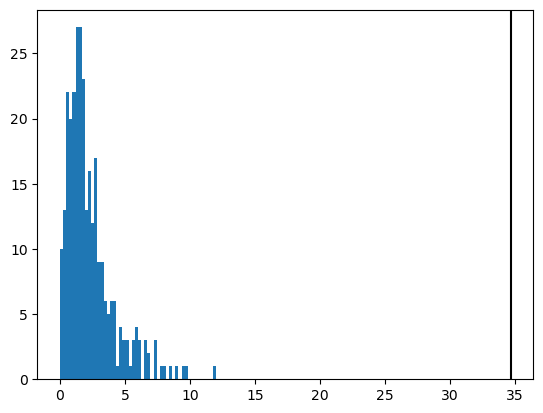

In [12]:
# plotting the F for one example cell
# I know this is a place cell. '50_05-05-elec36-LINS'
neurons = p_perm['neuron'].unique()
p_perm_sig = p_perm[p_perm['p_perm_F']<0.05]

ex_cell = combo_df[combo_df['neuron']=='50_05-05-elec36-LINS']
ex_cell_real = ex_cell[ex_cell["permuted"] == False].copy()
ex_cell_perms = ex_cell[ex_cell["permuted"] == True].copy()

F_perm = ex_cell_perms[(ex_cell_perms['term'] == 'A') & (ex_cell_perms['model'] == 'M1_main')]['F'].to_numpy()
F_real = ex_cell_real[(ex_cell_real['term'] == 'A') & (ex_cell_real['model'] == 'M1_main')]['F'].to_numpy()
plt.figure; 
_ = plt.hist(F_perm, bins = 50)
plt.axvline(F_real, color = 'black')
plt.title(f"empirical vs. permuted F- values for {row['neuron']} in {row['model']}")

In [13]:
fig, axes = plot_perm_significance_Fval(p_perm)


NameError: name 'plot_perm_significance_Fval' is not defined

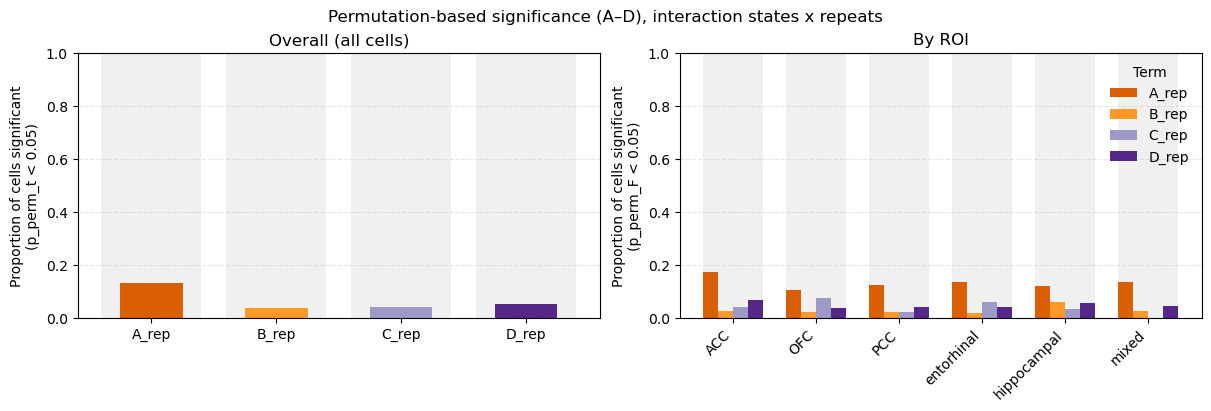

In [14]:
# interaction effect is a lot stronger for A: is getting more over-represented with repeats
fig, axes = plot_perm_significance_interaction_ABCD_cells(p_perm)


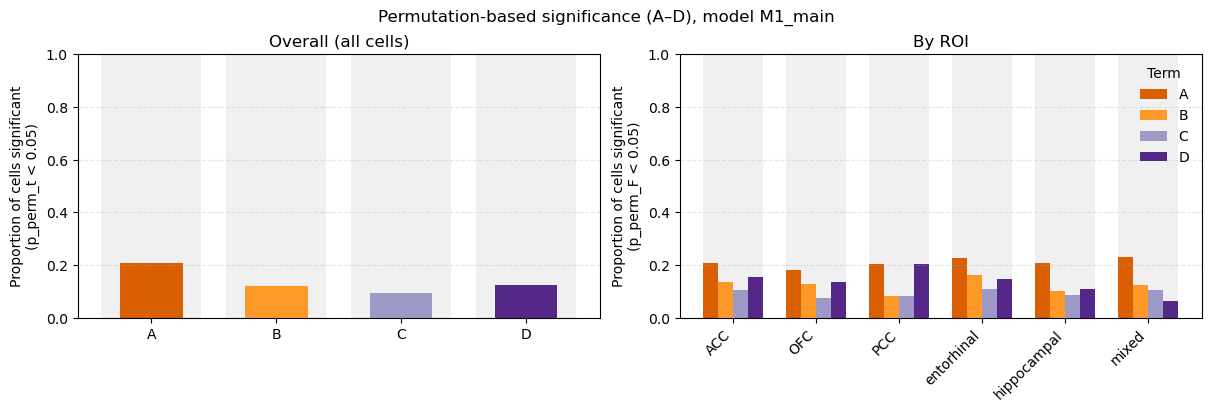

In [15]:
# A is particularly overrepresented, especially in hippocampus.
fig, axes = plot_perm_significance_ABCD_cells(p_perm)

In [44]:
p_perm.columns

Index(['Unnamed: 0.1', 'session', 'neuron', 'roi', 'model', 'term', 'beta',
       't', 'p', 'F', 'p_F', 'permuted', 'Unnamed: 0', 'p_perm_t', 'p_perm_F'],
      dtype='object')

In [15]:
# this was just to test out how to combine the permutations and empirical values. not needed anymore.
# select all permutations for this neuron and model.
perm_group = perms[mask]
print(len(perm_group))
t_real = row["t"]
F_real = row["F"]
print(f"t-val = {t_real} for {row['neuron']} in {row['term']}")
print(f"F-val = {F_real} for {row['neuron']} in {row['model']}")
t_perm = perm_group["t"].to_numpy()
F_perm = perm_group["F"].to_numpy()

# two-sided for t
p_t = (np.sum(np.abs(t_perm) >= abs(t_real)) + 1) / (len(t_perm) + 1)

# right-tailed for F
p_F = (np.sum(F_perm >= F_real) + 1) / (len(F_perm) + 1)

real.at[0, "p_perm_t"] = p_t
real.at[0, "p_perm_F"] = p_F


500


Text(0.5, 1.0, 'empirical vs. permuted F- values for 01_01-01-chan99-OFC in M1_main')

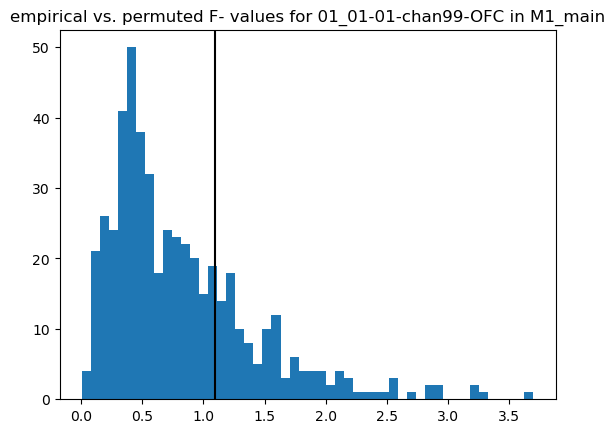

In [23]:
plt.figure; 
_ = plt.hist(F_perm, bins = 50)
plt.axvline(F_real, color = 'black')
plt.title(f"empirical vs. permuted F- values for {row['neuron']} in {row['model']}")


In [16]:
# next, load the state FR tuning analysis.
trials = 'all_minus_explore'
path = '/Users/xpsy1114/Documents/projects/multiple_clocks/data/ephys_humans/derivatives/group/state_tuning'
#file = 'pval_for_perms200_state_consistency_residualised_repeats_excl_gridwise_qc_pct_neurons.csv'
file = f'pval_for_perms200_state_consistency_{trials}_repeats_excl_gridwise_qc_pct_neurons.csv'

tuning_df = pd.read_csv(f"{path}/{file}")

In [68]:
tuning_df.columns
tuning_df.head()

,Unnamed: 0,session_id,neuron_id,state_cv_consistency,perm_idx,mean_firing_rate,sparse_repeats,pref_states,pref_state,roi,n_perms,p_perm,sig_FDR_all
0,0,1,01_01-01-chan99-OFC,-0.187641,0,5.526398,0,"['B', 'D', 'A', 'A', 'B', 'C']",A,OFC,150.0,0.794702,False
1,1,1,01_04-04-chan113-EC,-0.074806,0,0.752580,0,"['A', 'C', 'A', 'C', 'A', 'D']",A,entorhinal,150.0,0.589404,False
2,2,1,01_05-05-chan116-EC,0.298111,0,6.758461,0,"['D', 'D', 'A', 'A', 'D', 'B']",D,entorhinal,150.0,0.092715,False
3,3,1,01_06-06-chan119-EC,0.906830,0,2.730172,0,"['A', 'A', 'A', 'A', 'A', 'A']",A,entorhinal,150.0,0.006623,False
4,4,1,01_07-07-chan120-EC,-0.324155,0,0.845441,0,"['A', 'D', 'B', 'A', 'C', 'C']",A,entorhinal,150.0,0.973510,False


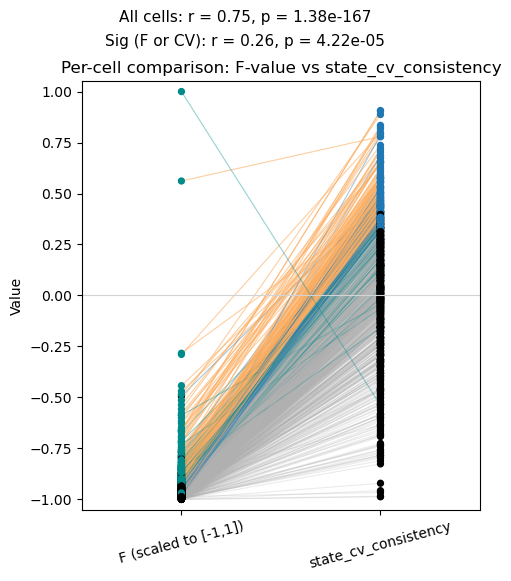

In [22]:
fig, ax, merged_df = plot_F_vs_state_cv(p_perm, tuning_df)


In [23]:
fig, axes, merged_df = plot_F_vs_state_cv_by_roi(p_perm, tuning_df)
# overall + only cells from ROI 'V1'
fig, axes, merged_df = plot_F_vs_state_cv_overall_and_roi(p_perm, tuning_df, roi_name="ACC")


NameError: name 'plot_F_vs_state_cv_by_roi' is not defined

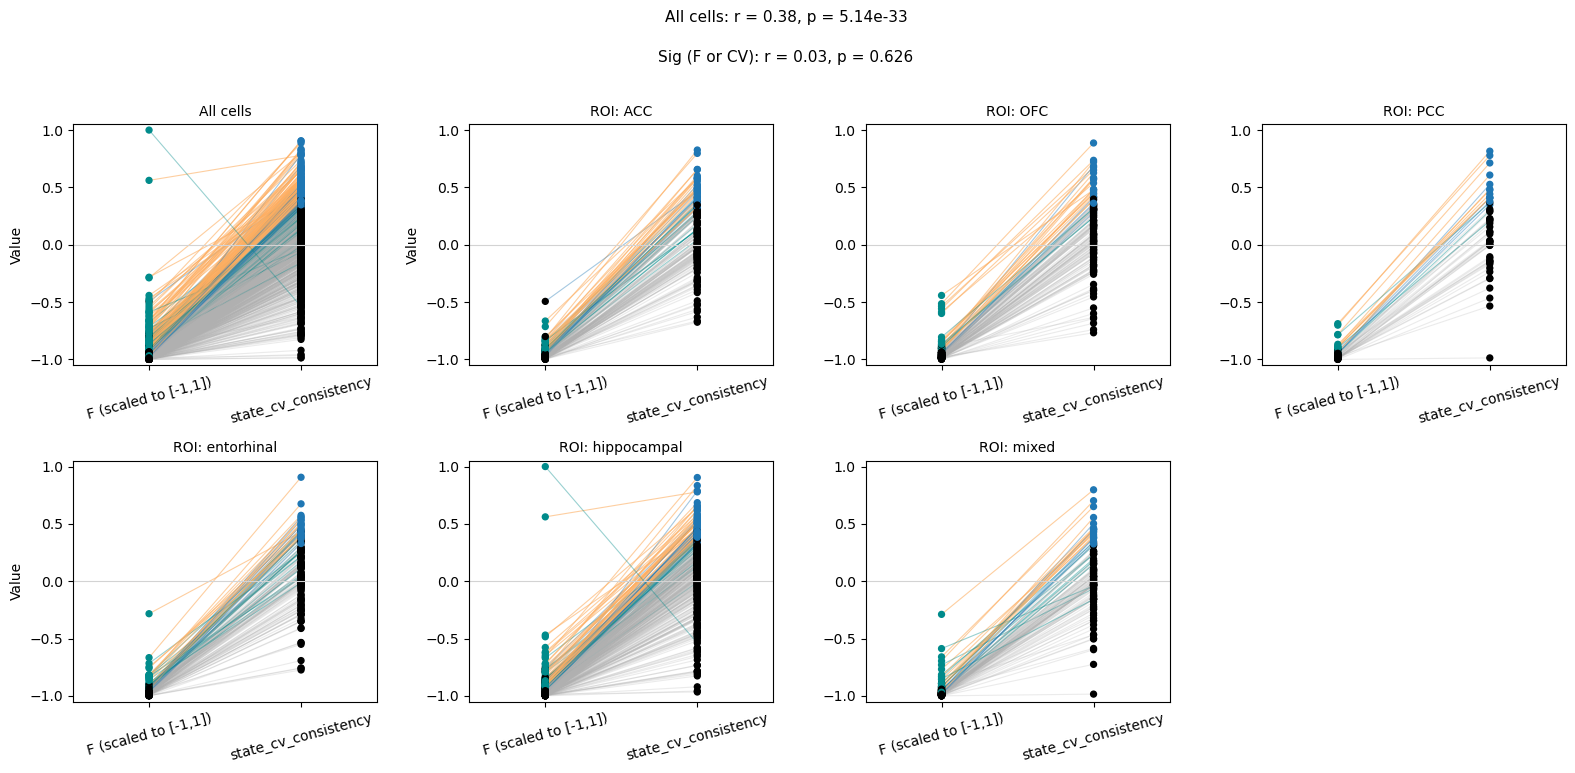

In [24]:
fig, axes, merged_df = plot_F_vs_state_cv_all_rois(p_perm, tuning_df)


In [18]:
# and now, for the actual correct parallel file - only correct trial.

# next, load the state FR tuning analysis.
trials = 'all_correct'
path = '/Users/xpsy1114/Documents/projects/multiple_clocks/data/ephys_humans/derivatives/group/state_tuning'
#file = 'pval_for_perms200_state_consistency_residualised_repeats_excl_gridwise_qc_pct_neurons.csv'
file = f'pval_for_perms200_state_consistency_{trials}_repeats_excl_gridwise_qc_pct_neurons.csv'

tuning_df = pd.read_csv(f"{path}/{file}")
tuning_df.head()


,session_id,neuron_id,state_cv_consistency,perm_idx,mean_firing_rate,sparse_repeats,pref_states,pref_state,roi,n_perms,p_perm,sig_FDR_all
0,1,01_01-01-chan99-OFC,-0.221439,0,5.556256,0,"['B', 'D', 'A', 'A', 'D', 'C']",A,OFC,150.0,0.814570,False
1,1,01_04-04-chan113-EC,0.021511,0,0.761747,0,"['A', 'C', 'A', 'C', 'A', 'D']",A,entorhinal,150.0,0.430464,False
2,1,01_05-05-chan116-EC,0.259398,0,6.736992,0,"['D', 'D', 'A', 'C', 'D', 'B']",D,entorhinal,150.0,0.132450,False
3,1,01_06-06-chan119-EC,0.910826,0,2.727863,0,"['A', 'A', 'A', 'A', 'A', 'A']",A,entorhinal,150.0,0.006623,False
4,1,01_07-07-chan120-EC,-0.140353,0,0.821568,0,"['A', 'D', 'B', 'A', 'B', 'C']",A,entorhinal,150.0,0.768212,False


In [2]:
fig, ax, merged_df = plot_F_vs_state_cv(p_perm, tuning_df)
fig, axes, merged_df = plot_F_vs_state_cv_by_roi(p_perm, tuning_df)
# overall + only cells from ROI 'V1'
fig, axes, merged_df = plot_F_vs_state_cv_overall_and_roi(p_perm, tuning_df, roi_name="ACC")
fig, axes, merged_df = plot_F_vs_state_cv_all_rois(p_perm, tuning_df)

NameError: name 'p_perm' is not defined

In [ ]:
# also load the permuted results.
# load the latest results.
source_dir = '/Users/xpsy1114/Documents/projects/multiple_clocks/data/ephys_humans/derivatives'
group_dir_state = f"{source_dir}/group/state_lin_regs"

trials = 'all_correct'
name_result = f"{group_dir_state}/state_rep_int_{trials}.csv"


In [4]:
# HELPERS
# to plot state plots
def plot_state_polar_clock(firing_across_states, title_string, ax=None, rlim=None):
    """
    Plot a polar curve like a clock:
      - 0° at 12 o'clock, clockwise (90°=3, 180°=6, 270°=9).
      - Colors the four equal angular quarters.
      - Places A,B,C,D at 3,6,9,12 o'clock respectively.
    """
    # Colors for quadrants A, B, C, D
    colors = ['#F15A29', '#F7931E', '#C7C6E2', '#6B60AA']
    letters = ['A', 'B', 'C', 'D']  # map to 3,6,9,12 o'clock

    vals = np.asarray(firing_across_states, dtype=float)
    n_bins = len(vals)
    if n_bins < 4:
        raise ValueError("Need at least 4 bins to define quadrants.")

    # Create or reuse axis
    created_fig = False
    if ax is None:
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(1, 1, 1, projection='polar')
        created_fig = True

    # --- Clock orientation ---
    ax.set_theta_zero_location('N')   # 0° at 12 o'clock
    ax.set_theta_direction(-1)        # clockwise

    # One angle per sample
    theta = np.linspace(0, 2*np.pi, n_bins, endpoint=False)

    # --- Plot each colored quadrant (use exact bin splits; no assumption about 360 bins) ---
    # 4 equal segments across n_bins
    edges = np.linspace(0, n_bins, 5, dtype=int)
    for i in range(4):
        s, e = edges[i], edges[i+1]
        if e > s:
            ax.plot(theta[s:e], vals[s:e], color=colors[i], linewidth=3)

    # --- r-limits ---
    if rlim is None:
        rmin = float(np.nanmin(vals))
        rmax = float(np.nanmax(vals))
    else:
        rmin, rmax = rlim
    ax.set_ylim(rmin, rmax)

    # --- Shaded wedges up to quadrant mean ---
    quad_means = []
    for i in range(4):
        s, e = edges[i], edges[i+1]
        quad_means.append(np.nanmean(vals[s:e]) if e > s else np.nan)
    quad_means = np.asarray(quad_means)

    # Center angle and width per quadrant (exact, even if bins not divisible by 4)
    for i in range(4):
        s, e = edges[i], edges[i+1]
        if e <= s: 
            continue
        center_idx = (s + e) / 2.0
        center_ang = (center_idx / n_bins) * 2*np.pi
        width = ((e - s) / n_bins) * 2*np.pi
        m = quad_means[i]
        if np.isfinite(m):
            ax.bar(center_ang,
                   max(0, m - rmin),
                   width=width,
                   bottom=rmin,
                   color=colors[i],
                   alpha=0.25,
                   edgecolor='none',
                   zorder=0,
                   align='center')

    # --- Labels at 3,6,9,12 o'clock: A,B,C,D ---
    # Angles in radians: 3→90°, 6→180°, 9→270°, 12→0°
    # label_angles = np.deg2rad([90, 180, 270, 0])
    # label_r = rmax*1.3
    # for lab, ang, col in zip(letters, label_angles, colors):
    #     ax.text(ang, label_r, lab, ha='center', va='bottom',
    #             fontsize=22, fontweight='bold', color=col)

    label_angles = np.deg2rad([0, 90, 180, 270])   # A(3), B(6), C(9), D(12)
    letters      = ['A', 'B', 'C', 'D']
    colors       = ['#F15A29', '#F7931E', '#C7C6E2', '#6B60AA']

    # Put labels a constant radial padding outside the data circle
    pad = 0.12 * (rmax - rmin) if np.isfinite(rmin) and np.isfinite(rmax) else 0.1
    label_r = rmax + pad
    
    for lab, ang, col in zip(letters, label_angles, colors):
        # Choose alignment by quadrant so text sits outside the circle:
        if np.isclose(ang, 0):            # 12 o'clock (D)
            ha, va = 'center', 'bottom'
        elif np.isclose(ang, np.pi/2):    # 3 o'clock (A)
            ha, va = 'left',   'center'
        elif np.isclose(ang, np.pi):      # 6 o'clock (B)
            ha, va = 'center', 'top'
        elif np.isclose(ang, 3*np.pi/2):  # 9 o'clock (C)
            ha, va = 'right',  'center'
        else:
            ha, va = 'center', 'center'
    
        ax.text(ang, label_r, lab,
                ha=ha, va=va, fontsize=28, fontweight='bold', color=col,
                clip_on=False)  # don't clip at axes boundary
        
    # Hide numeric theta ticks (keep grid if you like)
    ax.set_xticks([])

    # ax.set_title(title_string, va='bottom', fontsize=22)
    ax.grid(True)

    if created_fig:
        #plt.tight_layout()
        plt.show()

        
        
def smooth_circular(arr, sigma=2):
    """
    Apply Gaussian smoothing to circular data (like 360-bin polar plots).
    Wraps data before smoothing to avoid edge artifacts.
    """
    extended = np.concatenate([arr, arr, arr])  # tripled to allow wrap-around
    smoothed = gaussian_filter1d(extended, sigma=sigma)
    return smoothed[len(arr):2*len(arr)]  # return center part


In [5]:
# exclude session 39 because something went wrong here
results_df = results_df[results_df['session'] != 39]
print(len(results_df))
results_df.head()

14565


,Unnamed: 0,session,neuron,roi,model,term,beta,t,p,F,p_F
0,0,1,01_01-01-chan99-OFC,OFC,M1_main,A,-0.042089,-1.986949,0.046928,2.334877,0.053168
1,1,1,01_01-01-chan99-OFC,OFC,M1_main,B,-0.037729,-1.766428,0.077324,2.334877,0.053168
2,2,1,01_01-01-chan99-OFC,OFC,M1_main,C,-0.032211,-1.560763,0.118580,2.334877,0.053168
3,3,1,01_01-01-chan99-OFC,OFC,M1_main,D,-0.058933,-2.820865,0.004789,2.334877,0.053168
4,4,1,01_01-01-chan99-OFC,OFC,M1_main,rep_c,-0.000552,-0.327001,0.743667,2.334877,0.053168


OFC
entorhinal
ACC
hippocampal
PCC
mixed


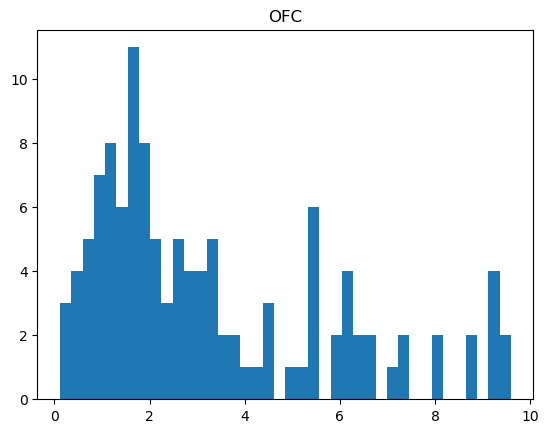

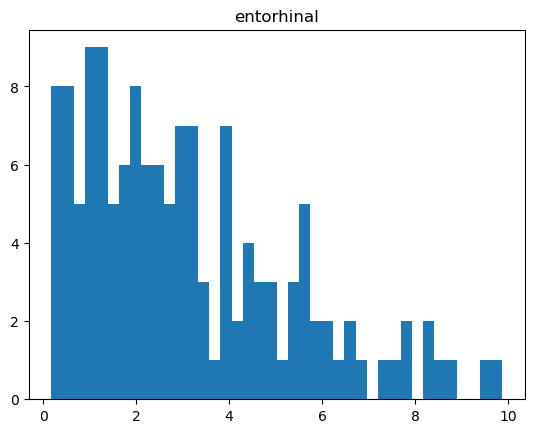

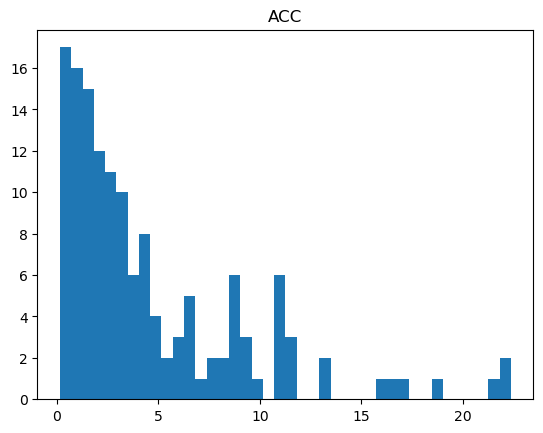

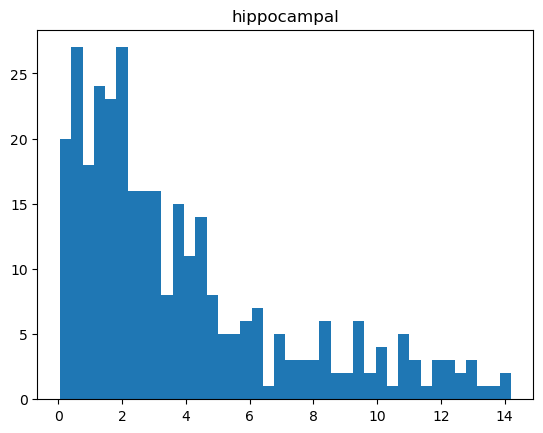

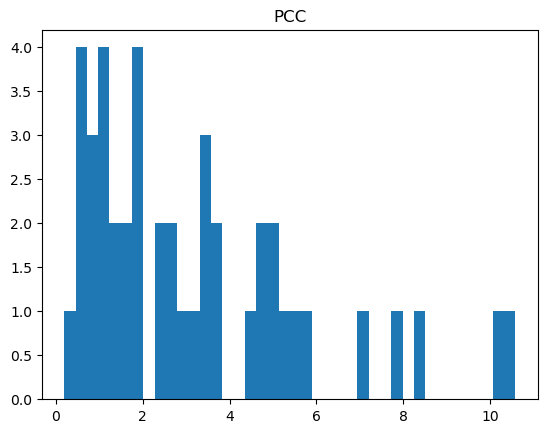

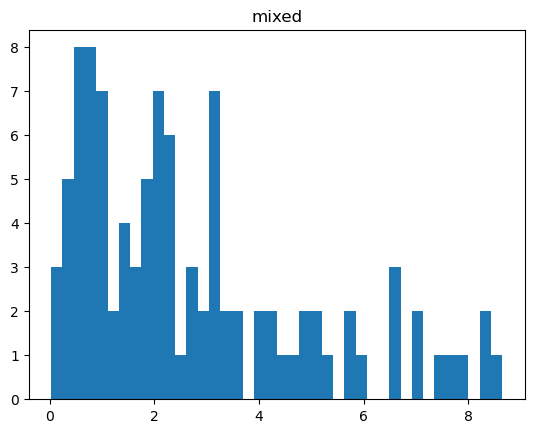

In [6]:
rois = results_df['roi'].unique()

for roi in rois:
    print(roi)
    main_effect_state_roi = results_df[(results_df['roi'] == roi) & (results_df['term'] == 'A') & (results_df['model'] == 'M1_main')].copy()
    x = main_effect_state_roi['F'].copy()
    thresh = np.quantile(np.abs(x), .90)
    plt.figure()
    _ = plt.hist(x[np.abs(x)<thresh], bins = 40)
    plt.title(roi)

OFC
entorhinal
ACC
hippocampal
PCC
mixed


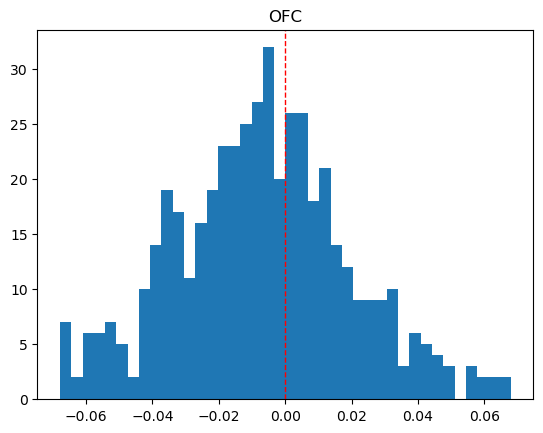

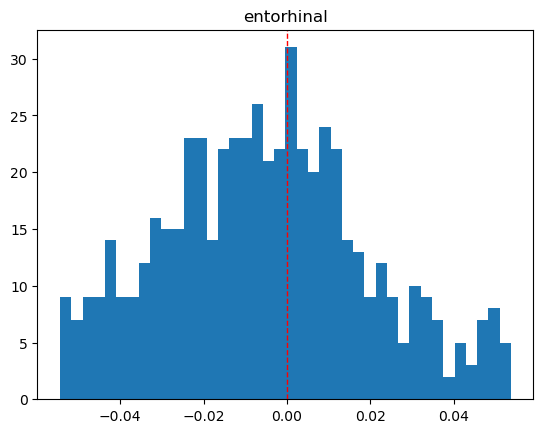

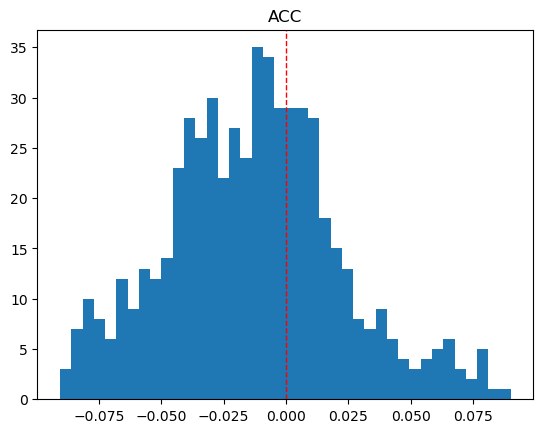

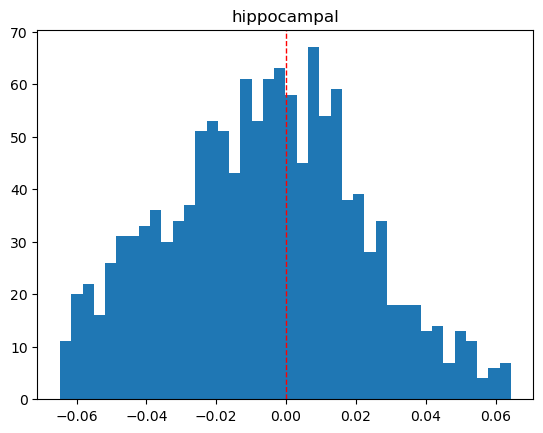

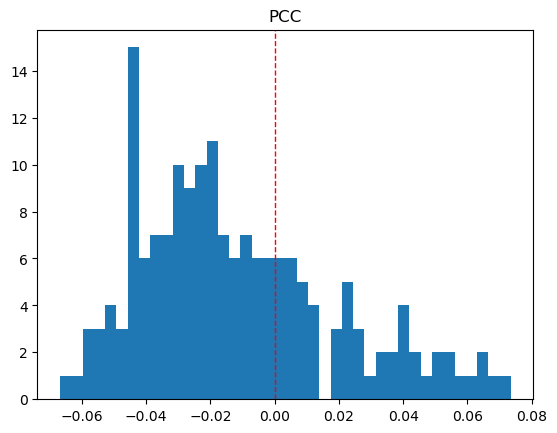

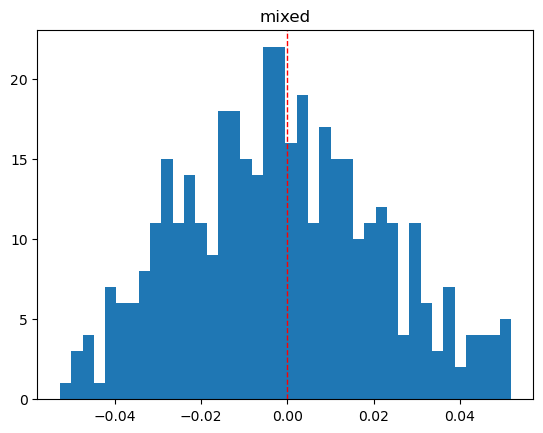

In [7]:
for roi in rois:
    print(roi)
    effect_state_roi = results_df[(results_df['roi'] == roi) & (results_df['term'] != 'rep_c') & (results_df['term'] != 'correct') & (results_df['model'] == 'M1_main')].copy()
    x = effect_state_roi['beta'].copy()
    thresh = np.quantile(np.abs(x), .90)
    plt.figure()
    _ = plt.hist(x[np.abs(x)<thresh], bins = 40)
    plt.axvline(0, ls="--", lw=1, c='red')
    plt.title(roi)

F threshold: 20.131120183574748


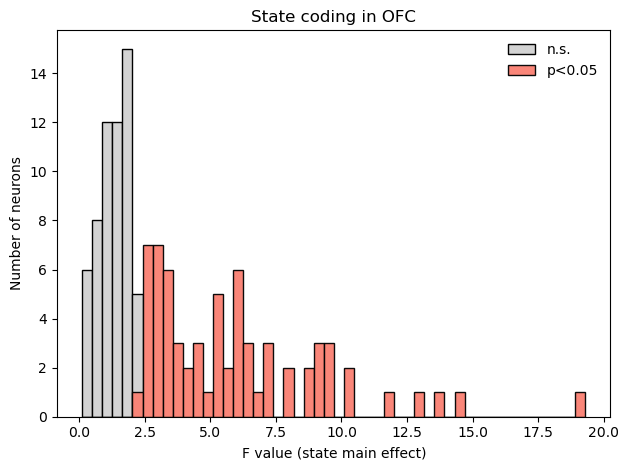

F threshold: 13.614440969296352


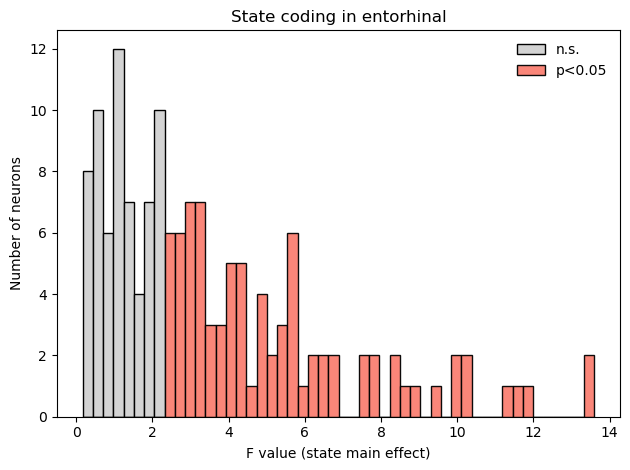

F threshold: 41.44777833702469


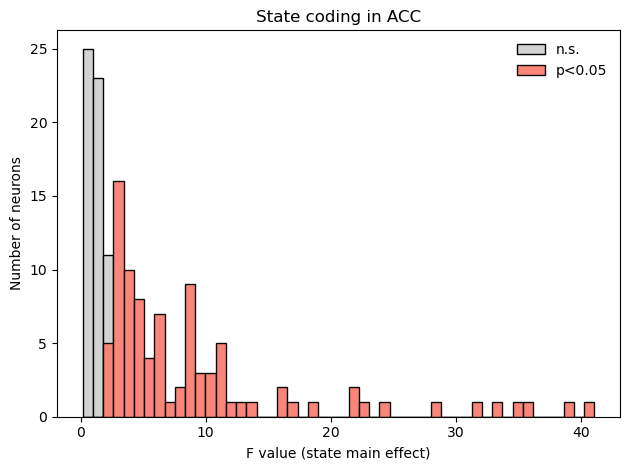

F threshold: 23.796321312780506


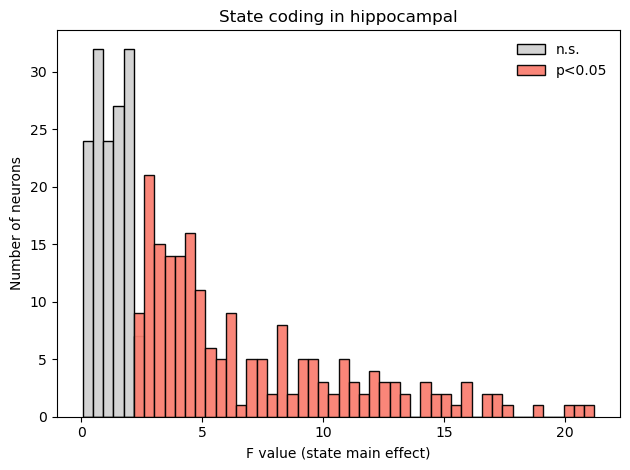

F threshold: 13.162363354298146


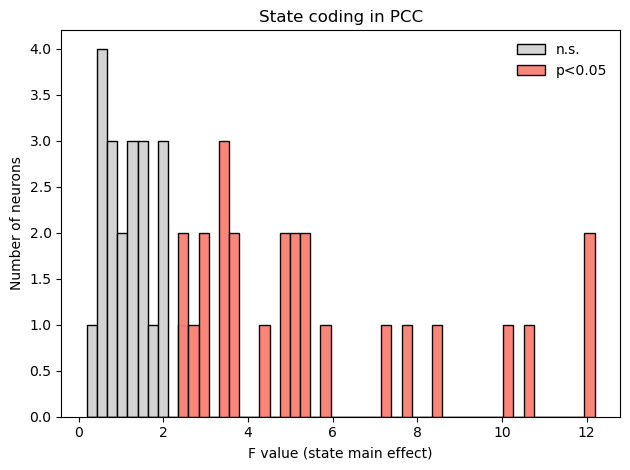

F threshold: 13.67122247017606


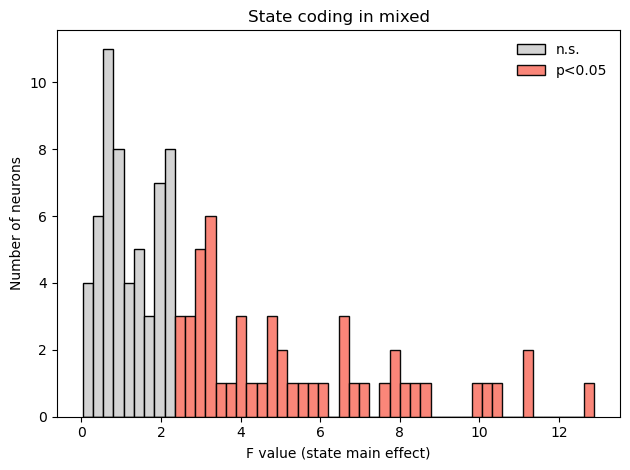

In [8]:
# 1) Keep only main-effect model rows, and one row per neuron
state_df = (
    results_df
    .query("model == 'M1_main'")
    [["session", "neuron", "roi", "F", "p_F"]]
    .drop_duplicates()
)
state_df.head()

for roi in rois:
    state_df_roi = state_df[state_df['roi'] == roi].copy()
    all_vals = state_df_roi["F"]
    thresh = np.quantile(np.abs(all_vals), .95)
    print("F threshold:", thresh)
    # also make sure none of the values is rediculously high.
    valid_mask = np.abs(state_df_roi["F"]) < thresh

    # 2) Split sig / non-sig, but only keep valid F values
    sig_mask    = (state_df_roi["p_F"] < 0.05) & valid_mask
    nonsig_mask = (state_df_roi["p_F"] >= 0.05) & valid_mask

    F_sig    = state_df_roi.loc[sig_mask, "F"]
    F_nonsig = state_df_roi.loc[nonsig_mask, "F"]

    # 3) Compute bin edges based only on valid values
    valid_F = state_df_roi.loc[valid_mask, "F"]
    bin_edges = np.histogram_bin_edges(valid_F, bins=50)

    plt.figure()
    _ = plt.hist(F_nonsig, bins = bin_edges, color='lightgray', edgecolor='black', alpha=1.0, label='n.s.')
    _ = plt.hist(F_sig, bins=bin_edges, color='salmon', edgecolor='black', alpha=0.95, label=f'p<0.05')


    plt.xlabel("F value (state main effect)")
    plt.ylabel("Number of neurons")
    plt.title(f"State coding in {roi}")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

t-val threshold: 7.75640312925963


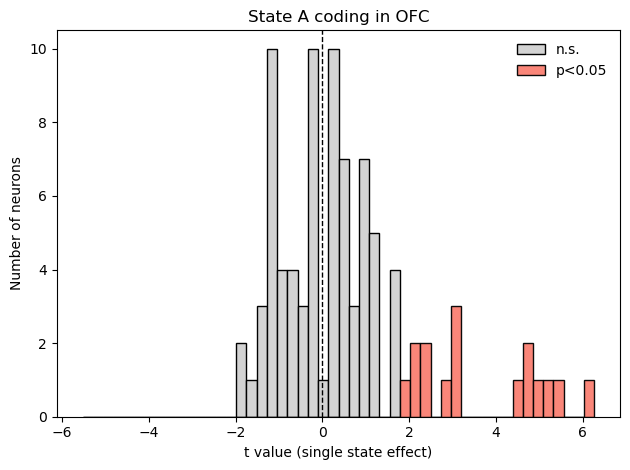

t-val threshold: 6.710707428788819


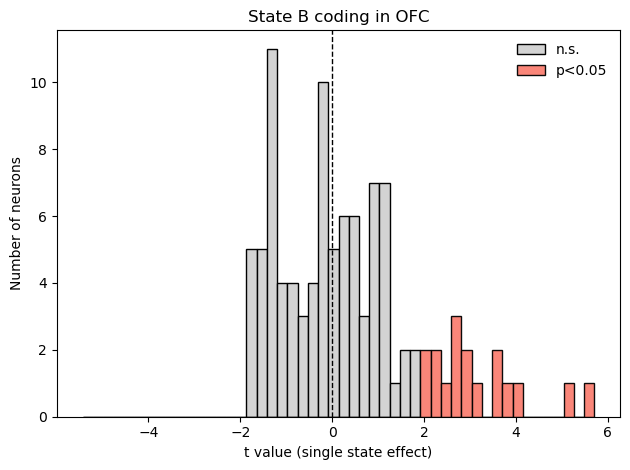

t-val threshold: 7.259868791060265


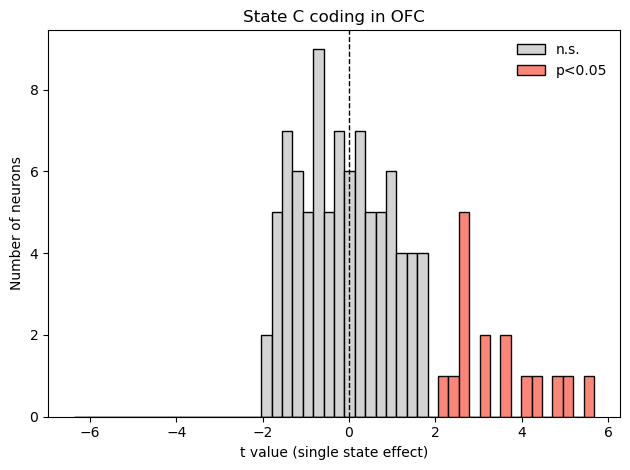

t-val threshold: 7.058586529282005


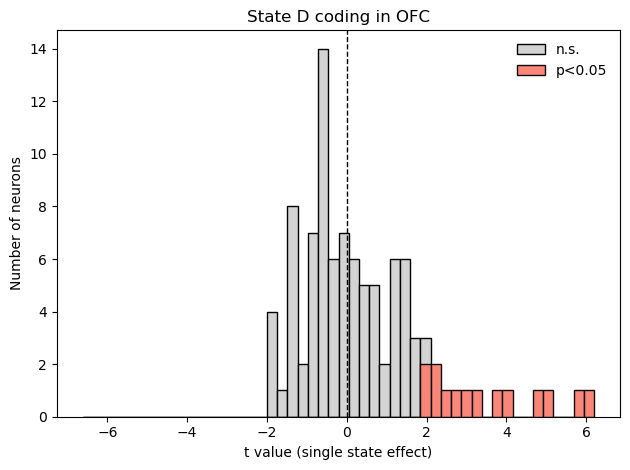

t-val threshold: 7.21957826186697


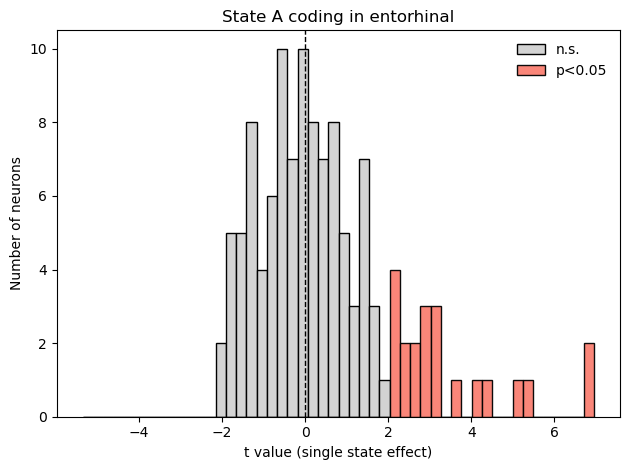

t-val threshold: 6.7056723558478515


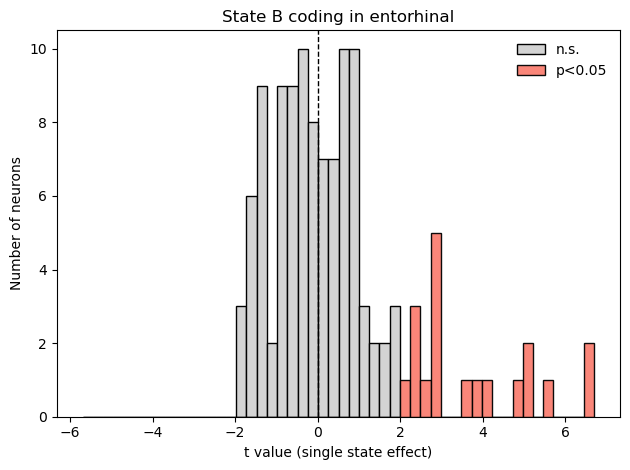

t-val threshold: 7.132056705365669


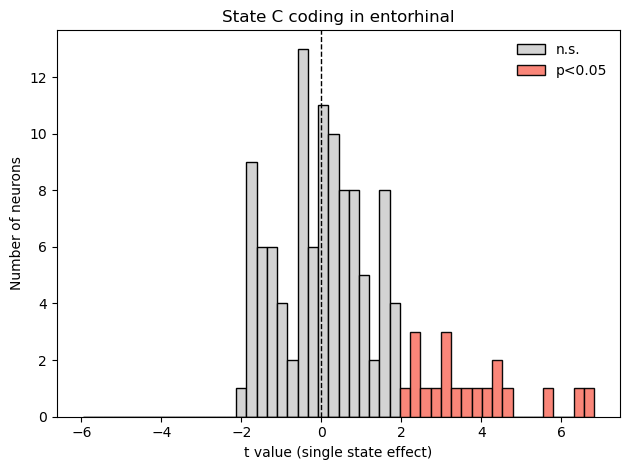

t-val threshold: 6.370492302989631


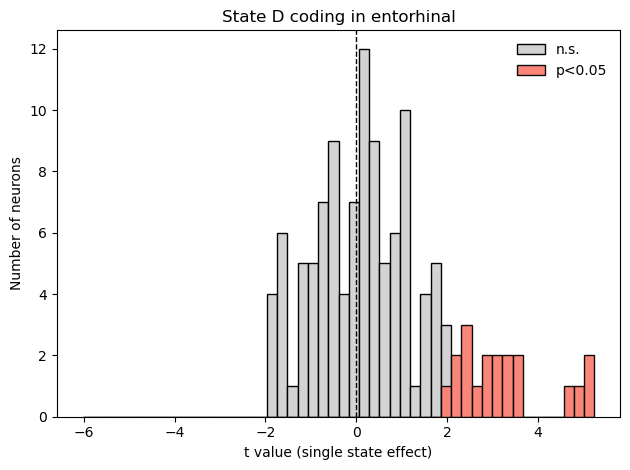

t-val threshold: 20.848943933964087


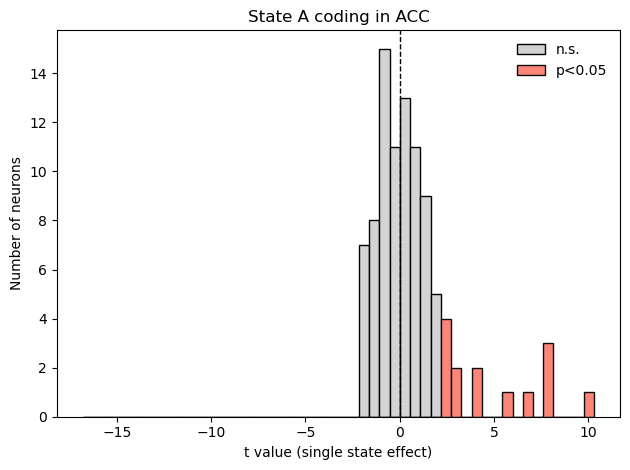

t-val threshold: 20.589341062357676


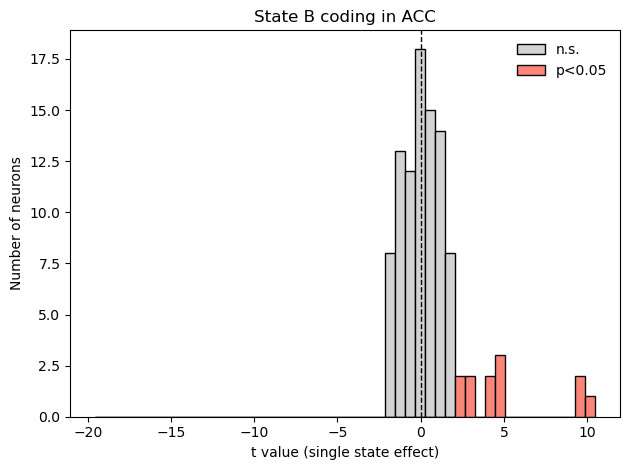

t-val threshold: 15.1933953537166


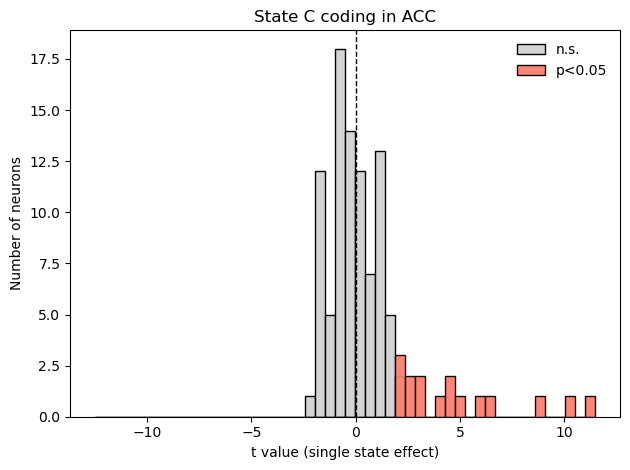

t-val threshold: 17.697602892913586


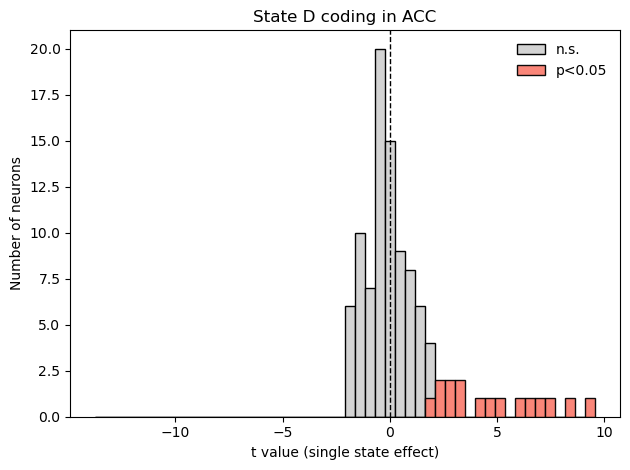

t-val threshold: 10.704337958218678


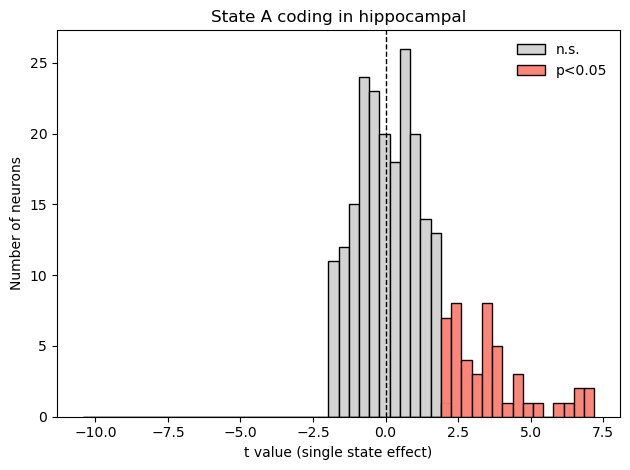

t-val threshold: 10.295945810368687


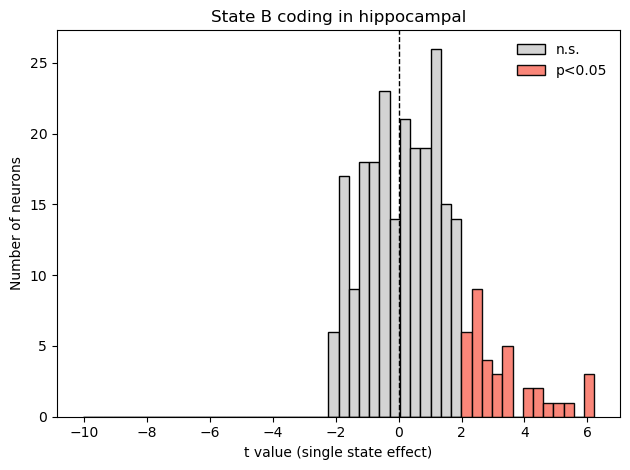

t-val threshold: 8.871700327127867


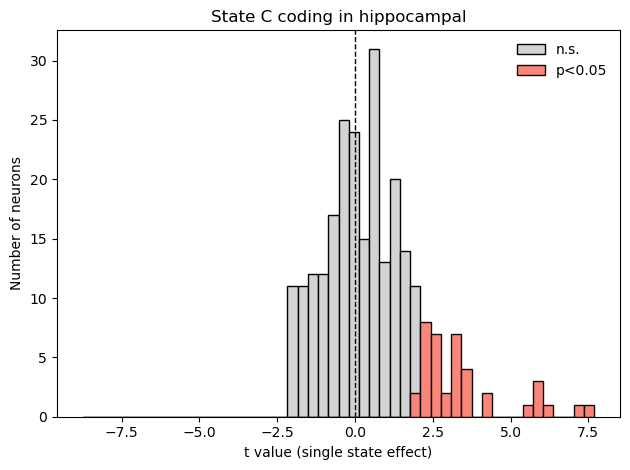

t-val threshold: 9.606864956769103


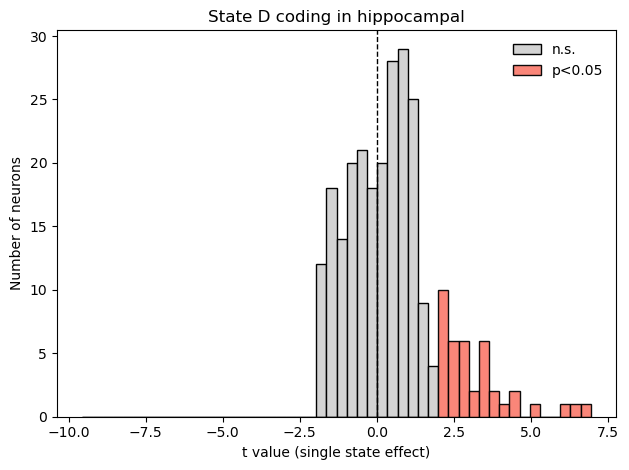

t-val threshold: 6.222765430965766


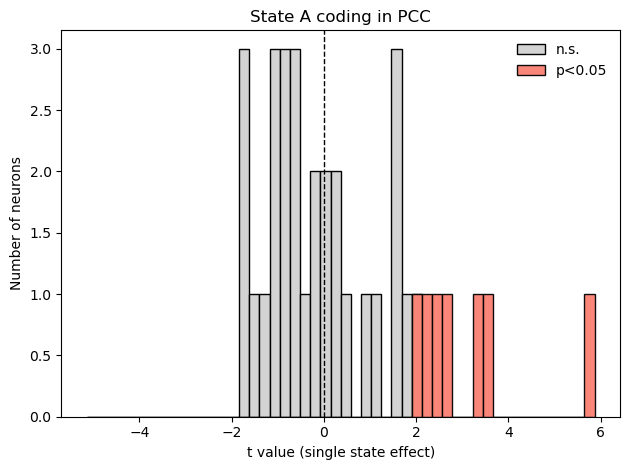

t-val threshold: 7.18283627720453


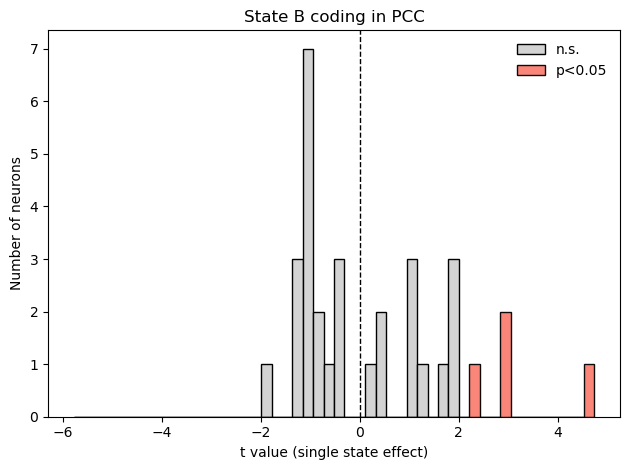

t-val threshold: 5.798655285454612


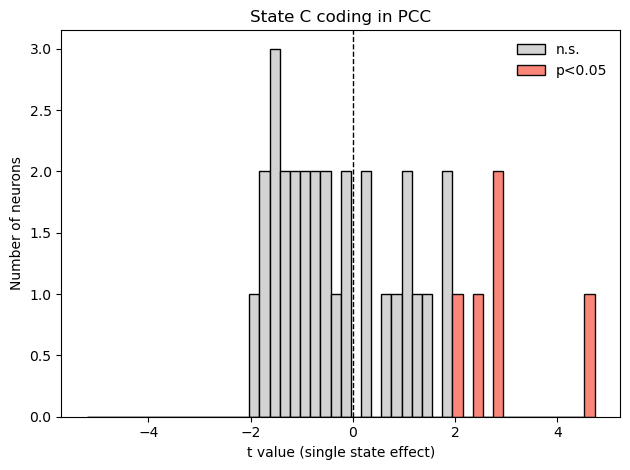

t-val threshold: 6.788415118785749


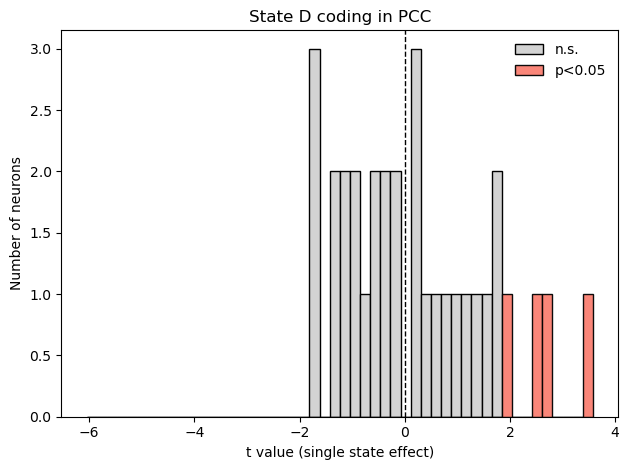

t-val threshold: 6.317875097509021


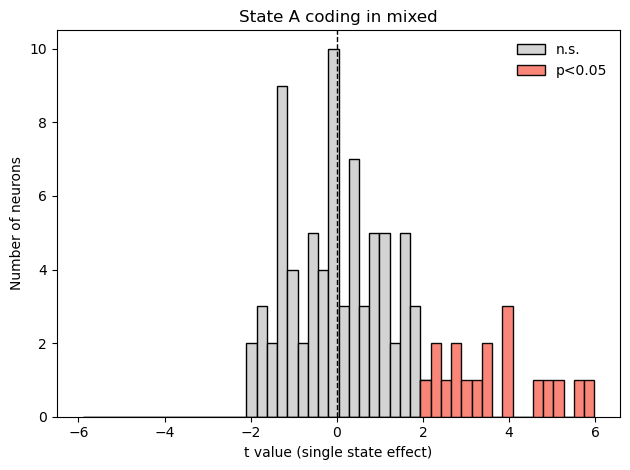

t-val threshold: 5.58447911041398


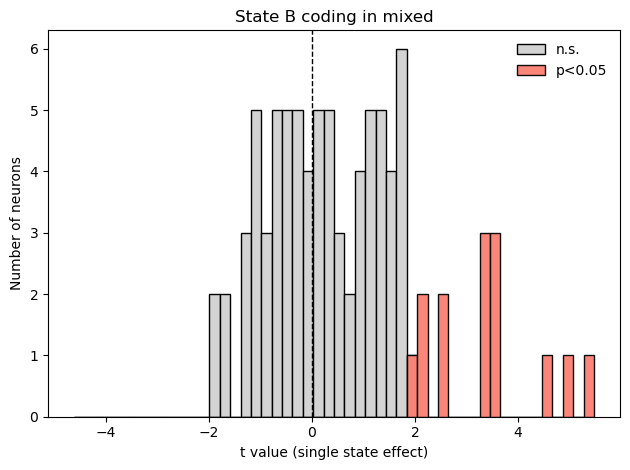

t-val threshold: 5.457143908514427


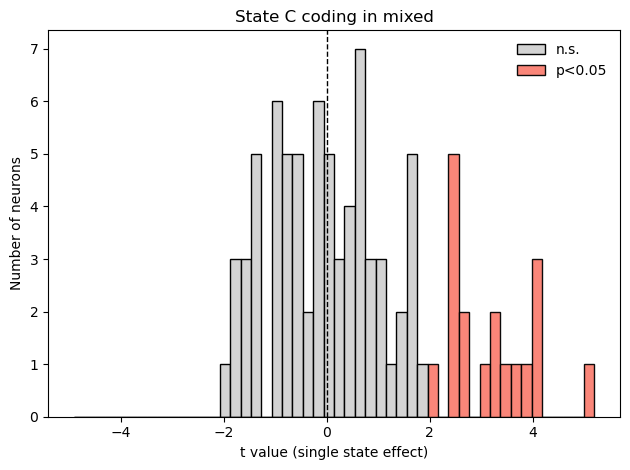

t-val threshold: 5.937079922431163


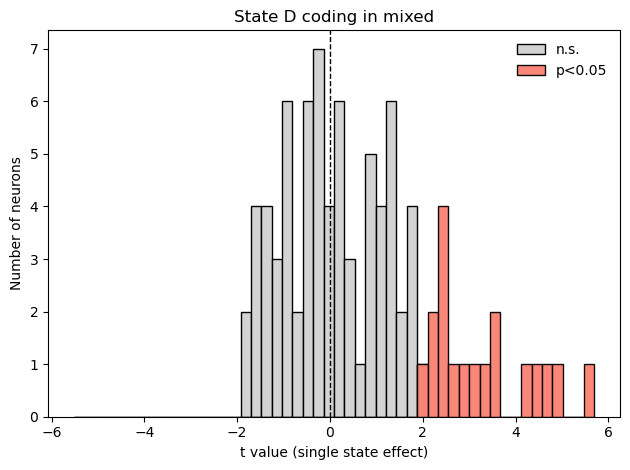

In [9]:
# 1) Keep only main-effect model rows, and one row per neuron
main_df = (
    results_df
    .query("model == 'M1_main'")
    [["session", "neuron", "roi", "term","t", "p"]]
    .drop_duplicates()
)
main_df.head()

for roi in rois:
    df_roi = main_df[main_df['roi'] == roi].copy()
    for state in ['A', 'B', 'C', 'D']:
        state_roi_df = df_roi[df_roi['term'] == state].copy()
state_roi_df.head()


for roi in rois:
    df_roi = main_df[main_df['roi'] == roi].copy()
    for state in ['A', 'B', 'C', 'D']:
        state_roi_df = df_roi[df_roi['term'] == state].copy()
        
        all_vals = state_roi_df['t']
        
        thresh = np.quantile(np.abs(all_vals), .99)
        print("t-val threshold:", thresh)

        # also make sure none of the values is rediculously high.
        valid_mask = np.abs(state_roi_df['t']) < thresh

        # 2) Split sig / non-sig, but only keep valid F values
        sig_mask    = (state_roi_df["p"] < 0.05) & valid_mask & (state_roi_df['t'] > 0)
        nonsig_mask = (state_roi_df["p"] >= 0.05) & valid_mask

        t_sig    = state_roi_df.loc[sig_mask, "t"]
        t_nonsig = state_roi_df.loc[nonsig_mask, "t"]

        # 3) Compute bin edges based only on valid values
        valid_t = state_roi_df.loc[valid_mask, "t"]
        bin_edges = np.histogram_bin_edges(valid_t, bins=50)

        plt.figure()
        _ = plt.hist(t_nonsig, bins = bin_edges, color='lightgray', edgecolor='black', alpha=1.0, label='n.s.')
        _ = plt.hist(t_sig, bins=bin_edges, color='salmon', edgecolor='black', alpha=0.95, label=f'p<0.05')
        plt.axvline(0, ls="--", lw=1, c='black')

        plt.xlabel("t value (single state effect)")
        plt.ylabel("Number of neurons")
        plt.title(f"State {state} coding in {roi}")
        plt.legend(frameon=False)
        plt.tight_layout()
        plt.show()

In [10]:
# next, plot single well-performing neurons.
# start from your existing state_df
state_df.head()

# make sure we have one row per neuron (M1_main, per neuron/roi/session)
state_unique = (
    state_df[["session", "neuron", "roi", "F", "p_F"]]
    .drop_duplicates()
    .copy()
)

# 1) Compute threshold for "reasonable" F-values (e.g. 95th percentile)
all_vals = state_unique["F"].astype(float)
thresh = np.quantile(np.abs(all_vals), 0.95)
print("F-value threshold (90th percentile of |F|):", thresh)

# 2) Keep only neurons with reasonable F
reasonable = state_unique[np.abs(state_unique["F"]) < thresh].copy()

# 3) Sort by F descending and take top 10
top10 = reasonable.sort_values("F", ascending=False).head(10)

# 4) Print them nicely
print("\nTop 10 neurons (reasonable F-values only):")
print(top10[["session", "neuron", "roi", "F", "p_F"]].to_string(index=False))

target_cells = top10['neuron'].to_list()

    

F-value threshold (90th percentile of |F|): 21.17637141868493

Top 10 neurons (reasonable F-values only):
 session                  neuron         roi         F          p_F
      61 61_14-14-mLF3aOFC05-OFC         OFC 21.152565 1.871218e-17
      25   25_35-35-mRT2bHb07-HC hippocampal 20.638909 5.097679e-17
      50    50_06-06-elec39-LINS       mixed 20.364048 8.712021e-17
      43   43_18-18-mRT2cHb03-HC hippocampal 20.020129 1.704174e-16
      48     48_08-08-mROFC4-OFC         OFC 19.295392 6.985398e-16
      60  60_16-16-GA3-RO5-OCCIP       mixed 19.179948 8.749157e-16
      12   12_17-17-mRT2bHb08-HC hippocampal 18.958890 1.345830e-15
      50     50_13-13-elec62-PCC         PCC 18.879186 1.572848e-15
      41   41_20-20-mRAMCC8-RAMC         ACC 18.839657 1.698975e-15
      10   10_13-13-mRT2bHb06-HC hippocampal 17.619970 1.821394e-14


In [11]:
chosen_top_neuron = 0

session = int(target_cells[chosen_top_neuron][0:2])
sesh = f"{session:02}"
#target_cells = top_sig_state_cells[top_sig_state_cells['session_id']==s]['neuron_id'].to_list()
#avg_corr_target_cells = top_sig_state_cells[top_sig_state_cells['session_id']==s]['state_cv_consistency'].to_list()
#rois = top_sig_state_cells[top_sig_state_cells['session_id']==s]['roi'].to_list()
#print(target_cells)

print(top10[top10['neuron'] == target_cells[idx]])


curr_neuron_results = results_df[(results_df['neuron'] == target_cells[idx]) & (results_df['model'] == 'M1_main')]
state_dict = {}
for state in ['A', 'B', 'C', 'D']:
    state_dict[f"{state}_p"] = curr_neuron_results[curr_neuron_results['term'] == state]['p'].to_numpy()
    state_dict[f"{state}_t"] = curr_neuron_results[curr_neuron_results['term'] == state]['t'].to_numpy()
print(state_dict)

data_folder = "/Users/xpsy1114/Documents/projects/multiple_clocks/data/ephys_humans/derivatives"
subjects = [sesh]
data_norm = mc.analyse.helpers_human_cells.load_norm_data(data_folder, subjects)


# the same script but for data norm
target_idx = [
    idx for idx, label_cell in enumerate(data_norm[f"sub-{sesh}"]['electrode_labels'])
    if any(target in label_cell or label_cell in target for target in target_cells)
]

print(target_idx)

# import pdb; pdb.set_trace()
# find out which grids are unique
grid_cols = ['loc_A', 'loc_B', 'loc_C', 'loc_D']
unique_grids, idx_unique_grid, idx_same_grids, counts = np.unique(
    data_norm[f"sub-{sesh}"]['beh'][grid_cols].to_numpy(),
    axis=0,
    return_index=True,
    return_inverse=True,
    return_counts=True
)

# AVERAGE OVER THE SAME GRIDS!!
# for i, unique_task_idx in enumerate(idx_unique_grid): 
#import pdb; pdb.set_trace()
for t_idx, target_cell in enumerate(target_cells):
    for curr_neuron in data_norm[f"sub-{sesh}"]['normalised_neurons']:
        if target_cell in curr_neuron:
            print(f"target cell is {target_cell}")
            #import pdb; pdb.set_trace()
            smoothed_firing_across_tasks = smooth_circular(np.mean(data_norm[f"sub-{sesh}"]['normalised_neurons'][curr_neuron].to_numpy(), axis = 0), sigma=4) 
            panels = [smoothed_firing_across_tasks]
            titles = ["TASK AVG"]

            for task_id, grid_config in enumerate(unique_grids):
                mask_curr_task = (idx_same_grids == task_id)
                neurons_curr_task = data_norm[f"sub-{sesh}"]['normalised_neurons'][curr_neuron].to_numpy()[mask_curr_task]
                avg_firing_curr_grid = list(np.mean(neurons_curr_task, axis = 0))
                smoothed_firing_curr_task = smooth_circular(avg_firing_curr_grid, sigma=4)  # tweak sigma as needed
                panels.append(smoothed_firing_curr_task)
                titles.append(f"task {grid_config}")

            # 3) make ONE figure with N polar subplots and shared r-limits (tiny addition)
            n_panels = len(panels)
            fig, axes = plt.subplots(1, n_panels, subplot_kw=dict(projection='polar'),
                                     figsize=(6*n_panels, 6))
            if n_panels == 1:
                axes = np.array([axes])

            # shared radial limits for fair comparison (NEW but minimal)
            rmin = float(np.nanmin([np.nanmin(p) for p in panels]))
            rmax = float(np.nanmax([np.nanmax(p) for p in panels]))
            rlim = (rmin, rmax)

            # 4) draw each panel using your SAME plotting function
            # for ax, series, title in zip(axes, panels, titles):
            #     plot_state_polar(series, title, ax=ax, rlim=rlim)
            for ax, series, title in zip(axes, panels, titles):
                plot_state_polar_clock(series, title, ax=ax, rlim=rlim)


            fig.suptitle(f"sub {sesh}; in {rois[t_idx]} {target_cell}", y=0.98, fontsize=13)
            plt.tight_layout()
            plt.show()

NameError: name 'idx' is not defined